In [2]:
##################################
### Import the usual libraries ###
##################################

#numpy
import numpy as np

# scipy
from scipy.stats import binned_statistic

#astropy
import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column, QTable

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

# Yumi's Code to convert (RA,DEC) to MS coordinates
import MagellanicStream as ms

# .py files for grad calc
import astrofunctions as astro
import lmcgeometry as lgeo
import mlefitting as mle
import utilities as util

# Ignore warnings unless crashes
import warnings
warnings.filterwarnings('ignore')

#progress bars
from tqdm import tqdm_notebook

In [3]:
pwd

'/Users/joshpovick/Research/LMC_Gradients_with_Ages'

In [5]:
# PARSEC Isochrones
parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Gradients_with_Ages/parsec3_3.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

# LMC r13 data
lmcr13 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Gradients_with_Ages/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
clnr = np.where((lmcr13['FE_H']>-9999.0)&(lmcr13['AK_TARG']>-9999.0)&(lmcr13['LOGG']>0.0)&
                (lmcr13['M_H_ERR']>-90.0)&(lmcr13['C_FE']>-9999.0)&(lmcr13['N_FE']>-9999.0))

r13 = lmcr13[clnr]

bloop = np.where((r13['H']<=13.25)&(r13['J']-r13['K']<=0.95)&(r13['TEFF']>=4175))
bloop_cut = []
for i in range(len(r13)):
    if i not in np.squeeze(bloop).tolist():
        bloop_cut.append(i)
        
r13_nobloop = r13[bloop_cut]
agb_cut = np.where(r13_nobloop['K']>12.5)
r13_nobloop_noagb =  r13_nobloop[agb_cut]

In [7]:
### Radii LMC
x,y,dist = lgeo.LMCdisk_cart(r13_nobloop_noagb['RA'],r13_nobloop_noagb['DEC'])
radius = lgeo.elliptical_radius(x,y)
     
### All elements APOGEE measures abundances for
elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']
elems_err = ['M_H_ERR','C_FE_ERR','N_FE_ERR','O_FE_ERR','NA_FE_ERR','MG_FE_ERR','AL_FE_ERR','SI_FE_ERR',
             'P_FE_ERR','S_FE_ERR','K_FE_ERR','CA_FE_ERR','TI_FE_ERR','TIII_FE_ERR','V_FE_ERR','CR_FE_ERR',
             'MN_FE_ERR','FE_H_ERR','CO_FE_ERR','NI_FE_ERR','CU_FE_ERR','GE_FE_ERR','RB_FE_ERR','CE_FE_ERR',
             'ND_FE_ERR','YB_FE_ERR']

labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe','[Ti/FE]','[Ti II/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge/Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/FE]']

# Initial MLE Fit

In [8]:
##############################
### Fit Overall Trendlines ###
##############################

med_ms = []
med_bs = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13_nobloop_noagb[elems[i]]>-100)&(r13_nobloop_noagb['SNR']>=100))
    
    # fit data
    slope, inter = mle.mle_fit(radius[cln],r13_nobloop_noagb[elems[i]][cln],r13_nobloop_noagb[elems_err[i]][cln])
    med_ms.append(slope)
    med_bs.append(inter)

In [9]:
for i in range(len(med_ms)):
    print('{}: slope: {:.4f}; inter: {:.4f}'.format(labs[i],med_ms[i],med_bs[i]))

[M/H]: slope: -0.0278; inter: -0.6379
[C/Fe]: slope: -0.0095; inter: -0.3240
[N/Fe]: slope: -0.0047; inter: 0.1151
[O/Fe]: slope: -0.0005; inter: 0.0419
[Na/Fe]: slope: -0.0076; inter: -0.1726
[Mg/Fe]: slope: 0.0012; inter: 0.1143
[Al/Fe]: slope: 0.0041; inter: -0.3778
[Si/Fe]: slope: 0.0056; inter: -0.0084
[P/Fe]: slope: 0.0051; inter: 0.1361
[S/Fe]: slope: -0.0041; inter: 0.2482
[K/Fe]: slope: -0.0017; inter: 0.0096
[Ca/Fe: slope: -0.0036; inter: 0.1104
[Ti/FE]: slope: nan; inter: -0.1043
[Ti II/Fe]: slope: -0.0035; inter: -0.0570
[V/Fe]: slope: -0.0016; inter: -0.1231
[Cr/Fe]: slope: -0.0050; inter: 0.0599
[Mn/Fe]: slope: -0.0276; inter: -0.0432
[Fe/H]: slope: -0.0257; inter: -0.6348
[Co/Fe]: slope: 0.0005; inter: -0.1547
[Ni/Fe]: slope: -0.0023; inter: -0.1234
[Cu/Fe]: slope: 0.0630; inter: 0.0119


'TI_FE'

In [16]:
matplotlib.rcParams.update({'font.size': 18})
med_elems_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return med_ms[i]*x+med_bs[i]
    
    cln = np.where((r13_nobloop_noagb[elems[i]]>-100)&(r13_nobloop_noagb['SNR']>=100))
    plug = trendline(radius[cln])
    dist = plug-r13_nobloop_noagb[elems[i]][cln]
    
    try:
        med_elems_dist.append(dist)    
    
        bins = np.append(np.arange(np.floor(np.min(radius[cln])),np.ceil(np.max(radius[cln])),1.0),
                     np.ceil(np.max(radius[cln]))+1) 
        bin_dist, _, _ = binned_statistic(radius[cln],dist,statistic='median',bins=bins)
        bin_spr, _, _ = binned_statistic(radius[cln],dist,statistic=lambda y: np.median(np.absolute(y-np.median(y))),
                                     bins=bins)
    except:
        med_elems_dist.append(-9999.0*np.ones(len(bins)))
    
#     plt.figure(figsize=[12,10])
#     plt.scatter(radius[cln],dist,marker='+')
#     plt.errorbar(bins[:-1]+0.5,bin_dist,yerr=3*bin_spr,c='r',ls='none',lw=3)
#     plt.errorbar(bins[:-1]+0.5,bin_dist,yerr=bin_spr,c='k',capsize=5,lw=3)
#     plt.axhline(0.0,c='g',lw=3.0)
#     plt.title(r'{}'.format(labs[i]),fontsize=30,x=0.85,y=0.90)#,len(np.squeeze(cln))))
#     plt.xlabel(r'Elliptical Radius (kpc)')
#     plt.ylabel(r'Distance from Initial Line Fit (kpc)')
#     plt.savefig('outliers{}'.format(elems[i]),bbox_inches='tight')
#     plt.show()

In [17]:
med_m_devs = []
med_b_devs = []
re_med_ms = []
re_med_bs = []

prune_fact = 3.
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((r13_nobloop_noagb[elems[i]]>-100)&(r13_nobloop_noagb['SNR']>=100))
    prune = np.where((r13_nobloop_noagb[elems[i]]>-prune_fact*util.mad(med_elems_dist[i])+
                      np.median(r13_nobloop_noagb[cln][elems[i]]))&
                     (r13_nobloop_noagb[elems[i]]<prune_fact*util.mad(med_elems_dist[i])+
                      np.median(r13_nobloop_noagb[cln][elems[i]])))

    exog = radius[prune]
    endog = r13_nobloop_noagb[elems[i]][prune]
    endog_err = r13_nobloop_noagb[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    med_m_devs.append(util.mad(slps))
    med_b_devs.append(util.mad(ints))
    
    re_med_ms.append(np.median(slps))
    re_med_bs.append(np.median(ints))

In [18]:
for i in range(len(re_med_ms)):
    print('{}: slope: {:.4f} +/- {:.4f} inter: {:.4f} +/- {:.4f}'.format(elems[i],re_med_ms[i],med_m_devs[i],
                                                                         re_med_bs[i],med_b_devs[i]))

M_H: slope: -0.0223 +/- 0.0052 inter: -0.6195 +/- 0.0194
C_FE: slope: -0.0129 +/- 0.0039 inter: -0.2969 +/- 0.0171
N_FE: slope: -0.0038 +/- 0.0042 inter: 0.0963 +/- 0.0177
O_FE: slope: -0.0022 +/- 0.0014 inter: 0.0486 +/- 0.0040
NA_FE: slope: 0.0139 +/- 0.0093 inter: -0.2347 +/- 0.0386
MG_FE: slope: 0.0002 +/- 0.0013 inter: 0.1152 +/- 0.0031
AL_FE: slope: -0.0003 +/- 0.0053 inter: -0.3604 +/- 0.0219
SI_FE: slope: 0.0062 +/- 0.0019 inter: -0.0032 +/- 0.0068
P_FE: slope: 0.0218 +/- 0.0096 inter: 0.0722 +/- 0.0397
S_FE: slope: 0.0015 +/- 0.0188 inter: 0.2022 +/- 0.0714
K_FE: slope: -0.0000 +/- 0.0094 inter: 0.0123 +/- 0.0308
CA_FE: slope: -0.0026 +/- 0.0009 inter: 0.1077 +/- 0.0035
TI_FE: slope: -9999.0000 +/- 0.0000 inter: -9999.0000 +/- 0.0000
TIII_FE: slope: -9999.0000 +/- 0.0000 inter: -9999.0000 +/- 0.0000
V_FE: slope: -0.0057 +/- 0.0036 inter: -0.1066 +/- 0.0119
CR_FE: slope: -0.0092 +/- 0.0023 inter: 0.0688 +/- 0.0082
MN_FE: slope: nan +/- nan inter: -0.0432 +/- 0.0129
FE_H: slope:

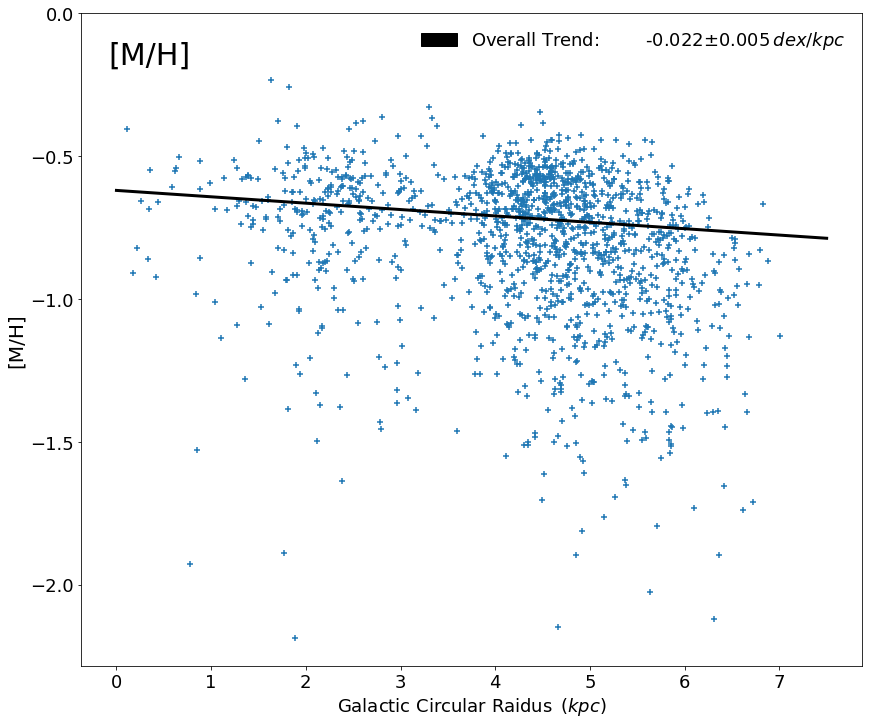

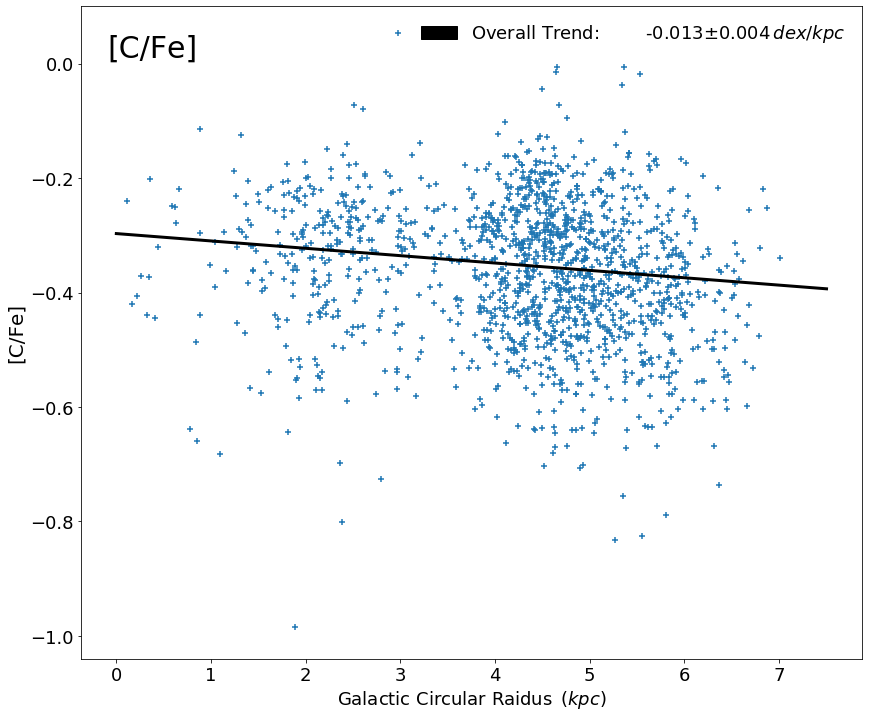

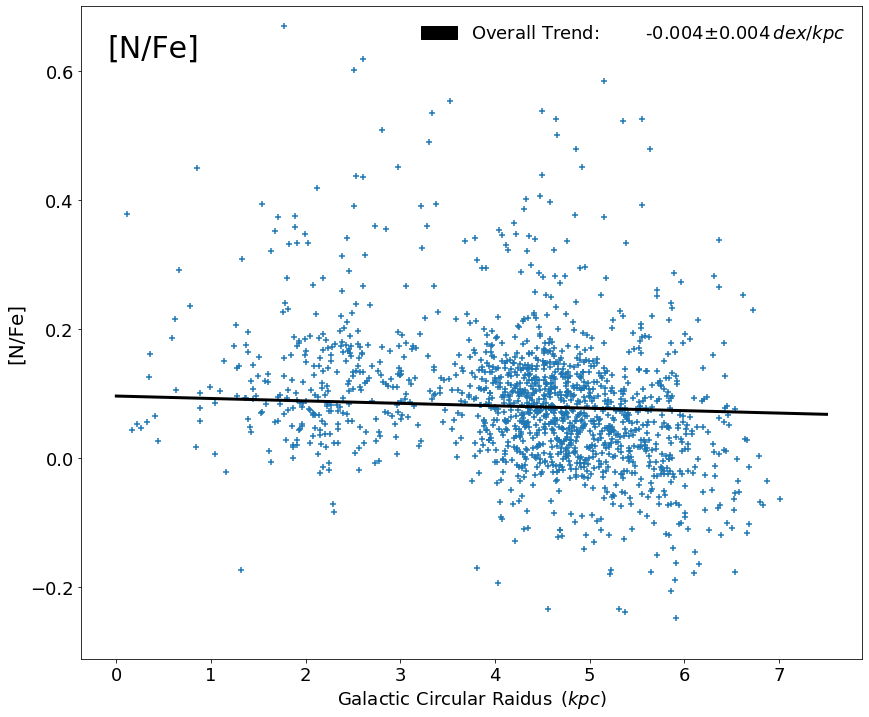

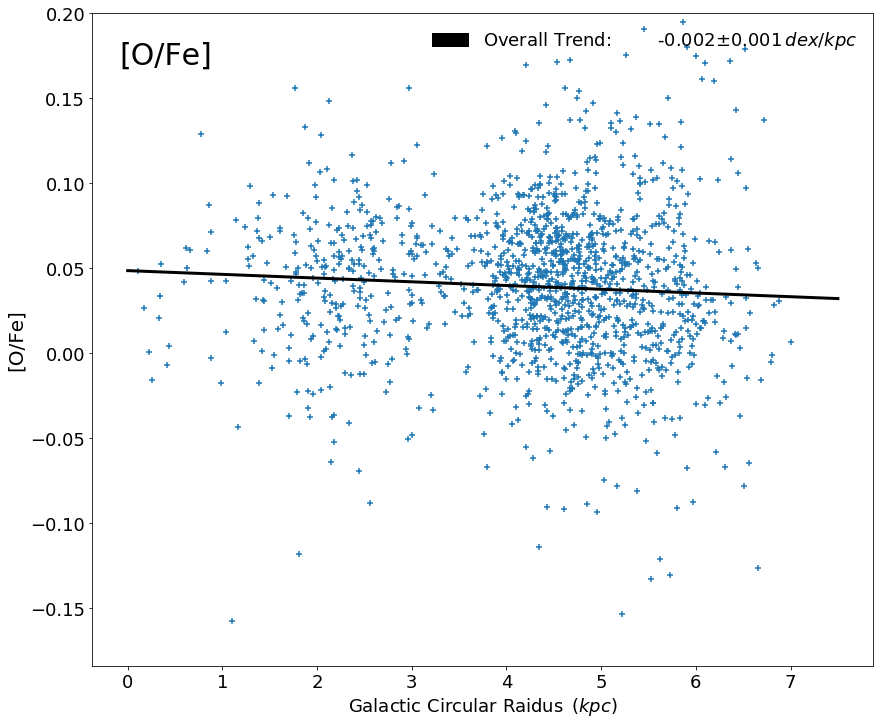

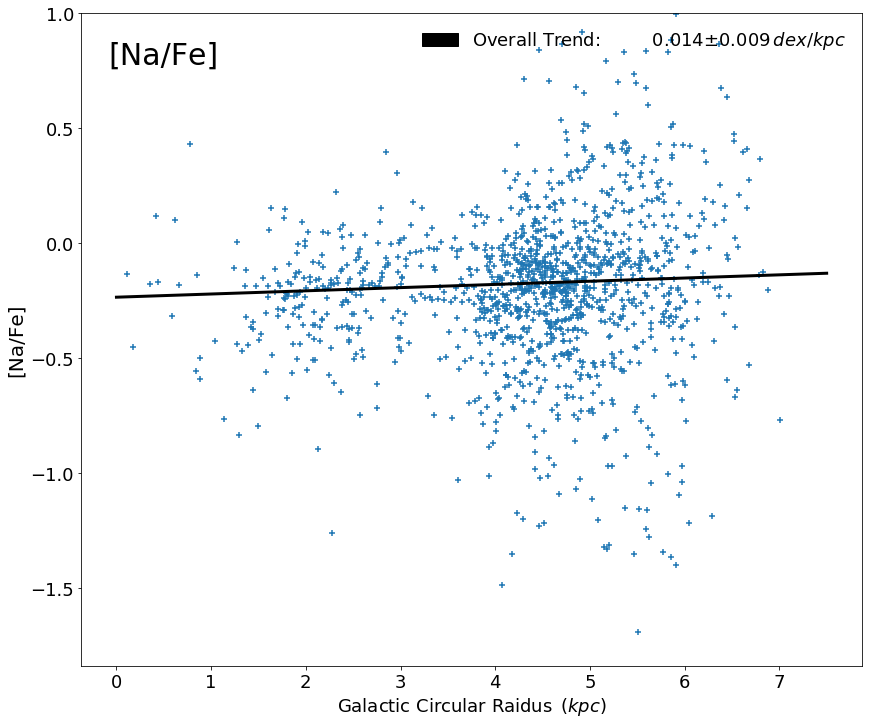

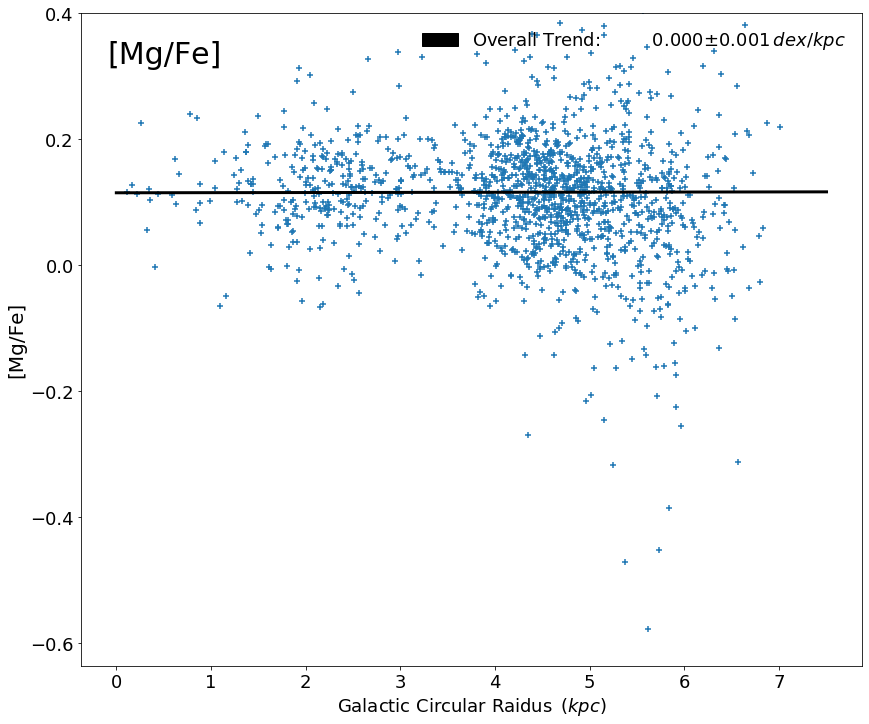

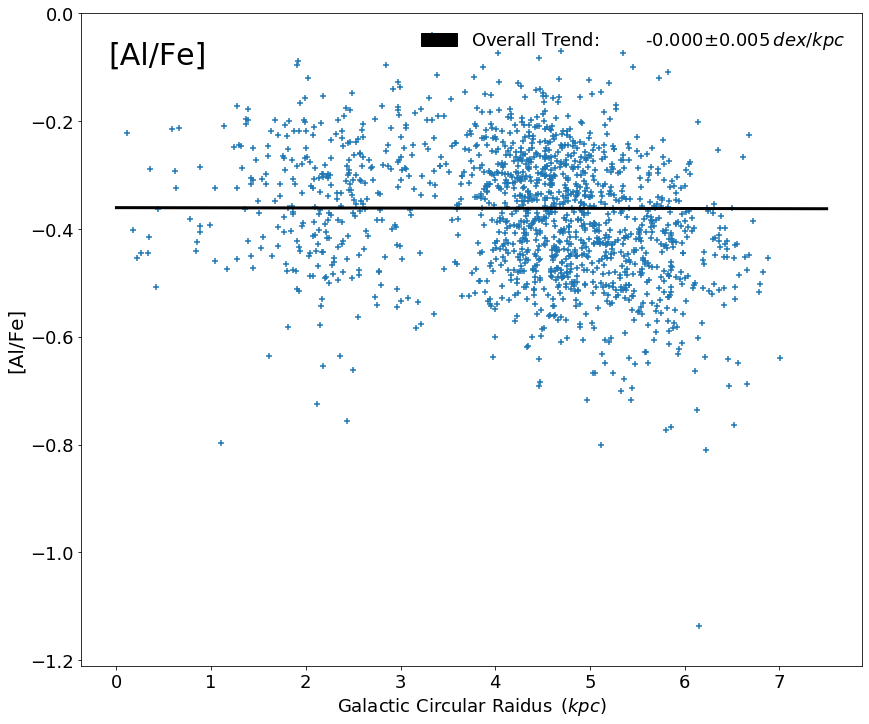

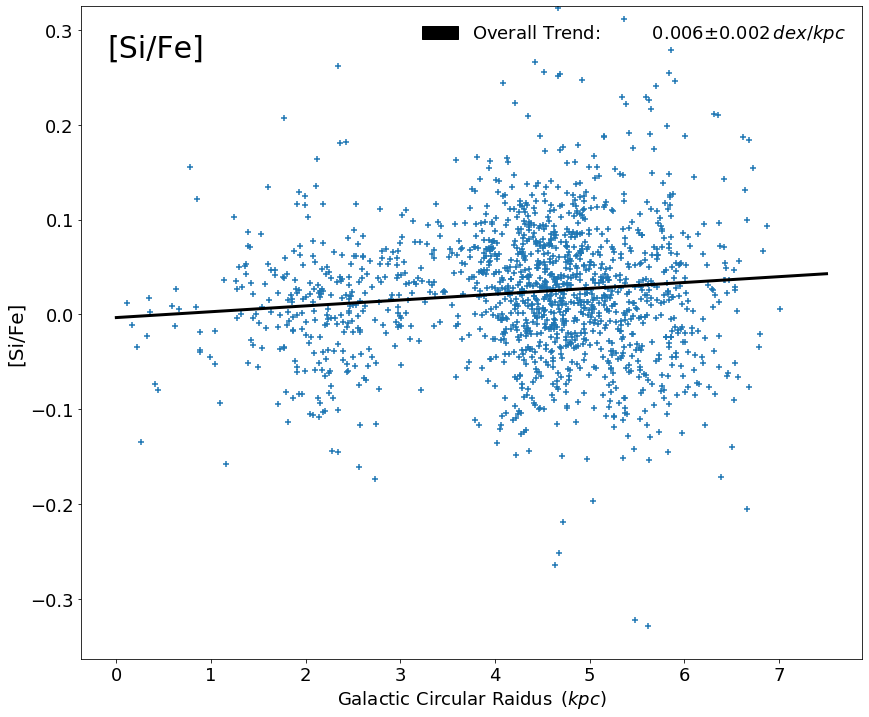

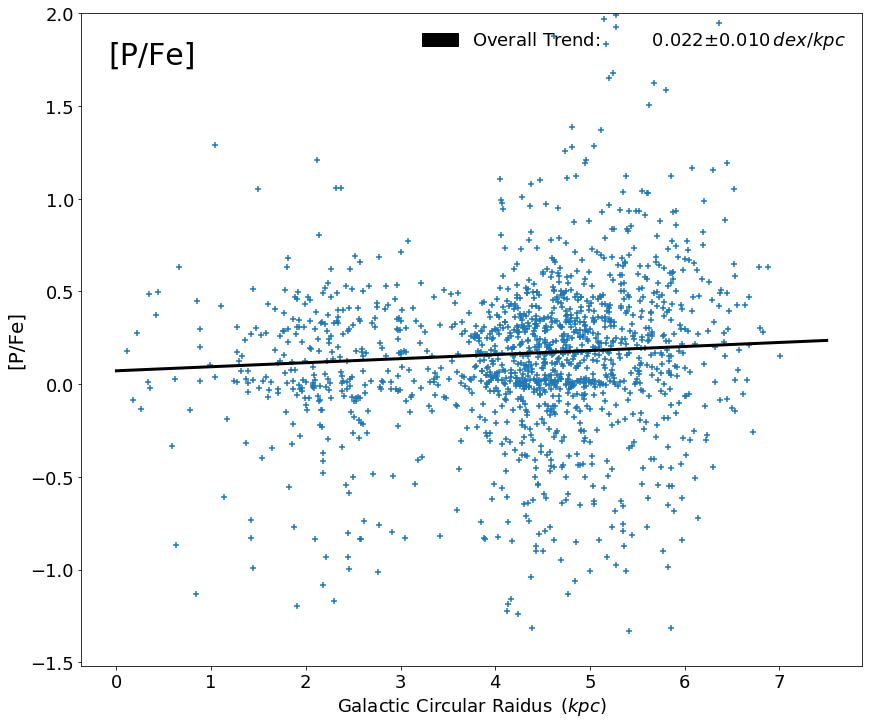

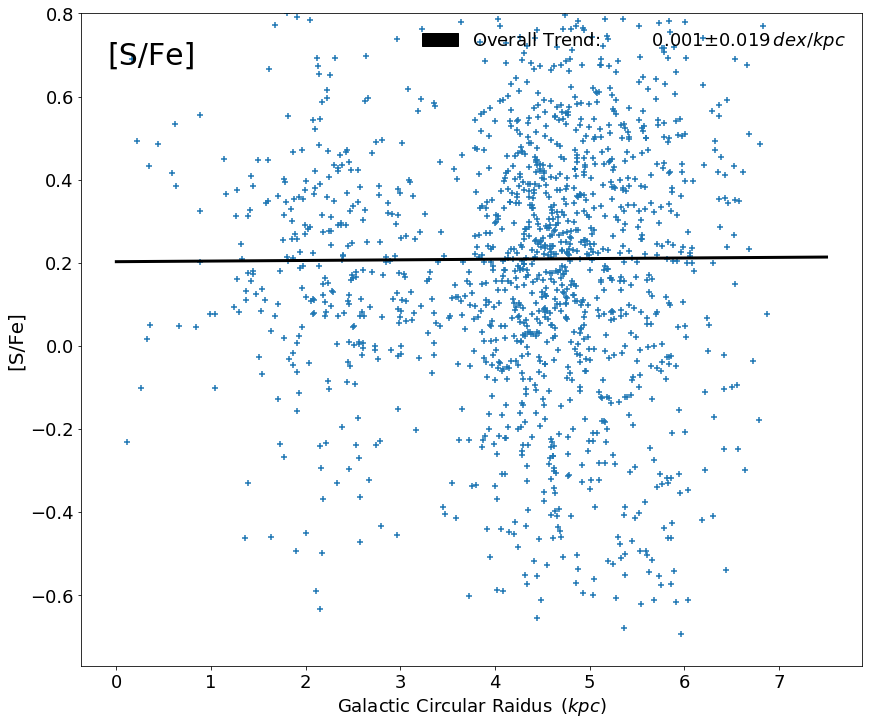

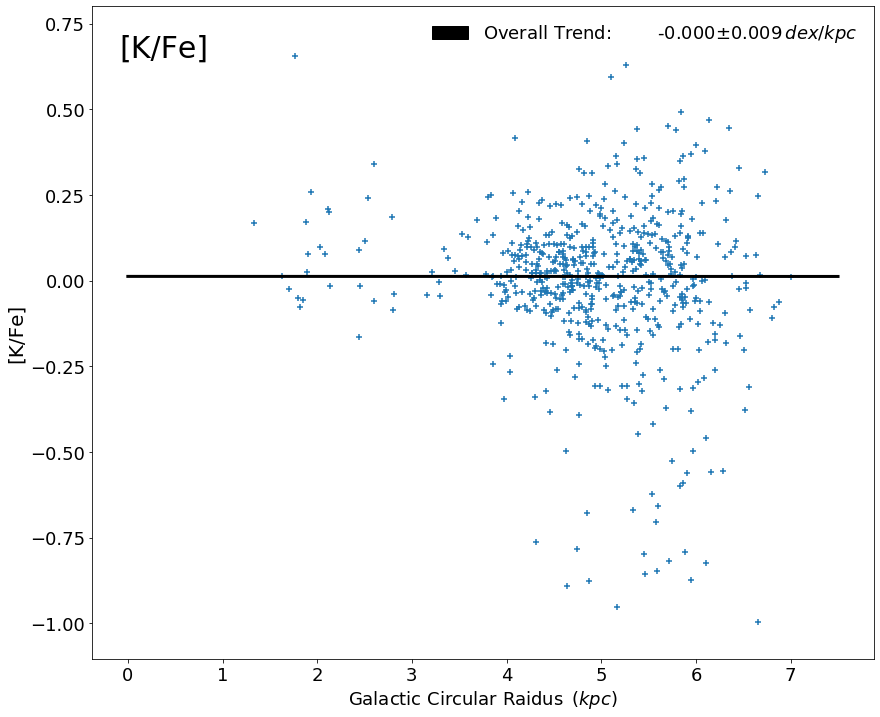

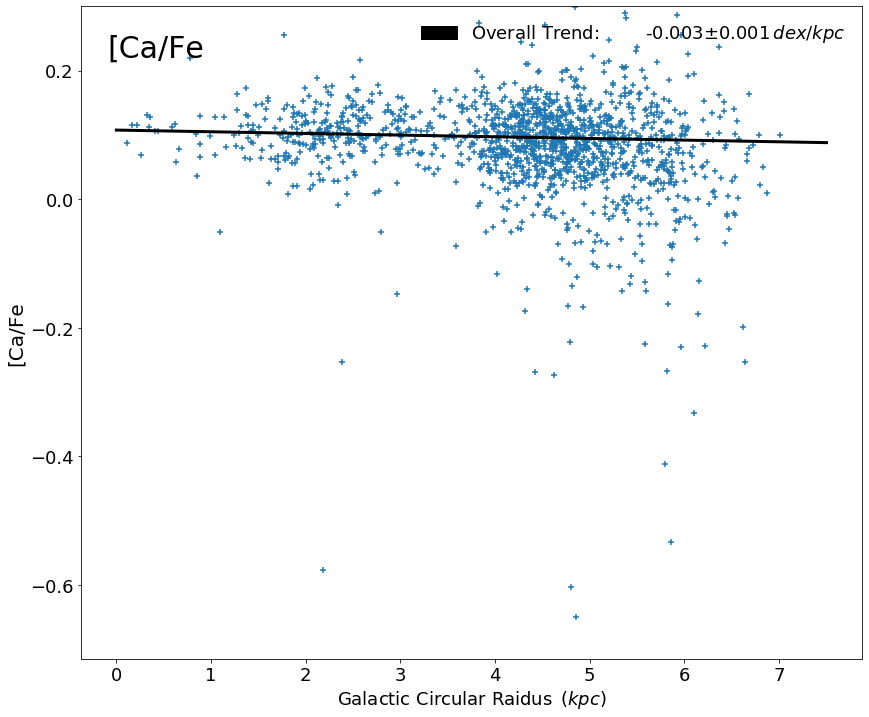

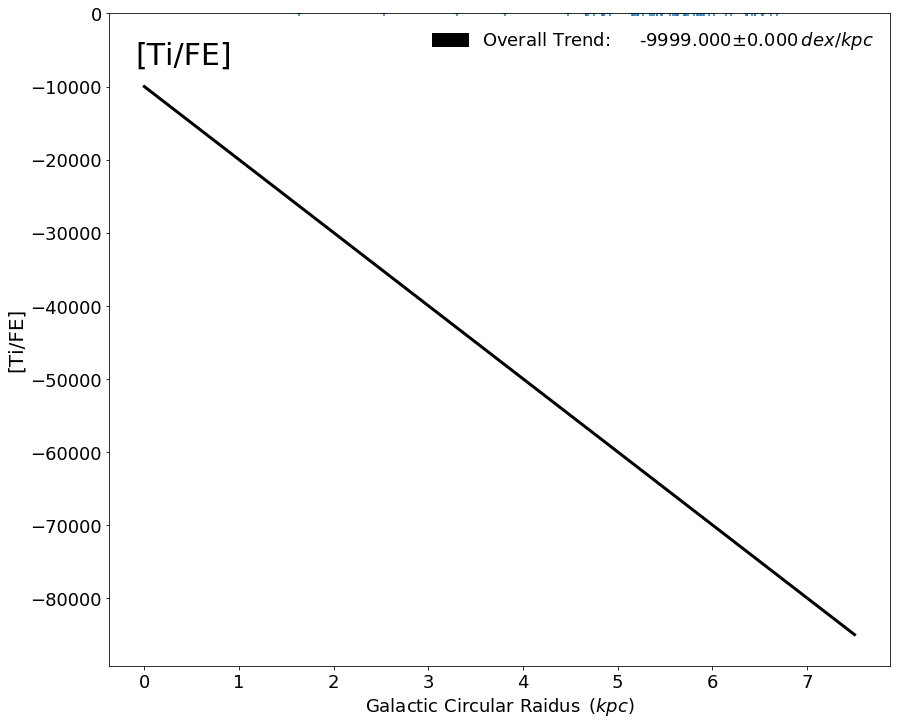

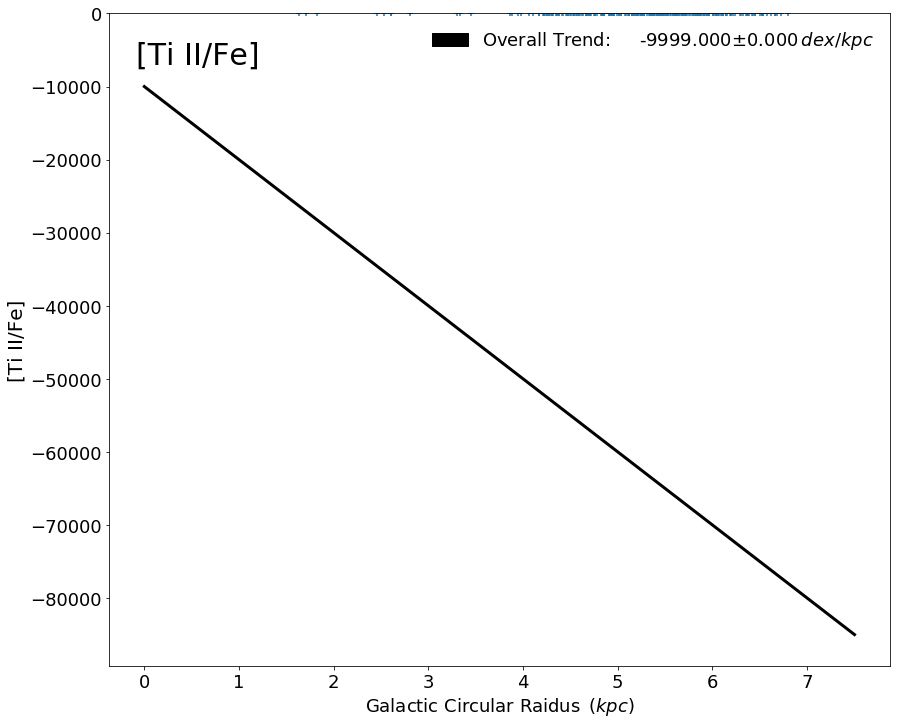

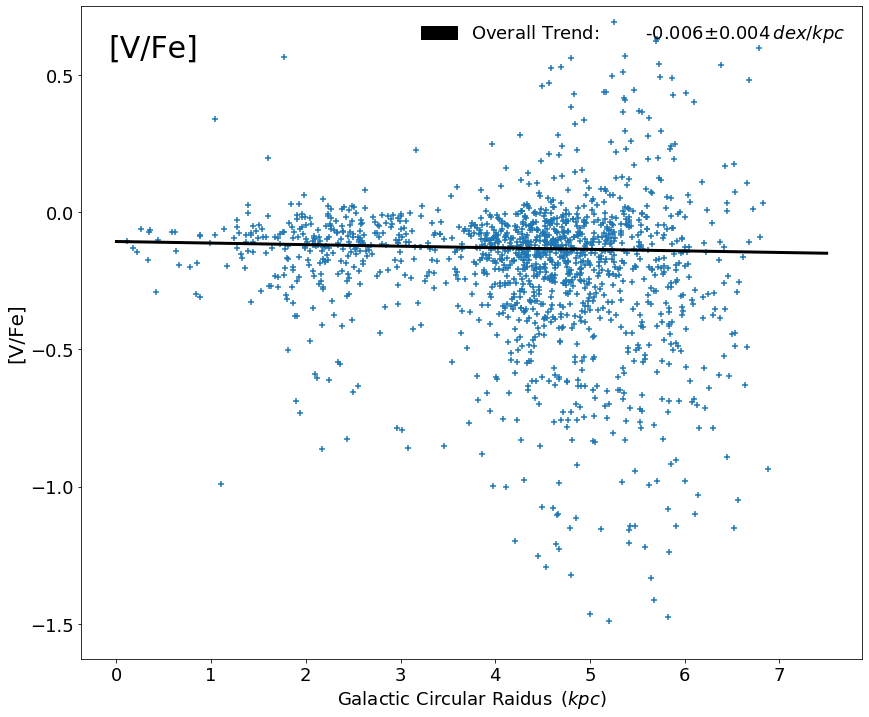

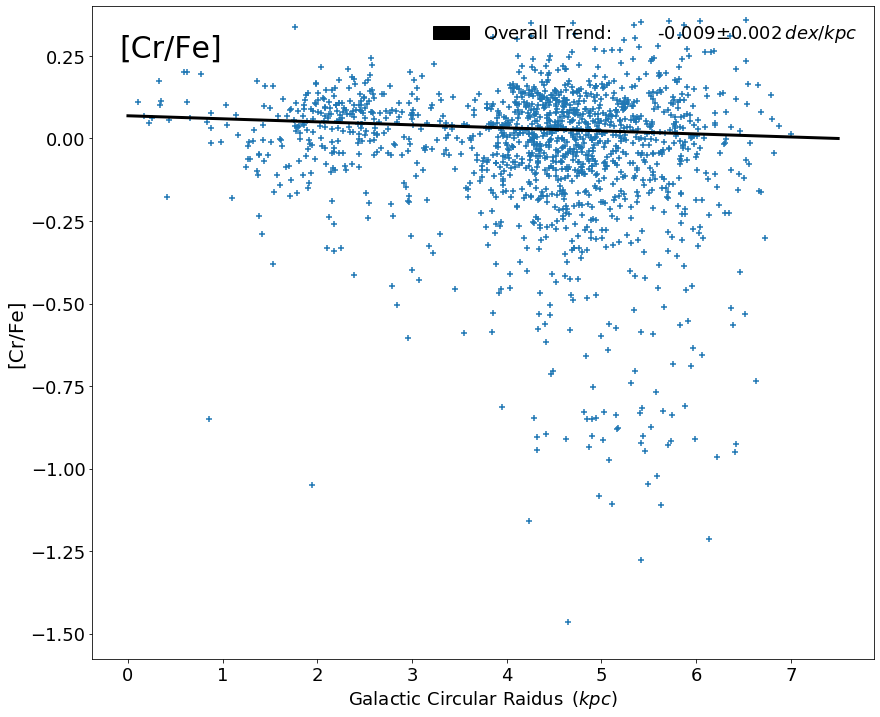

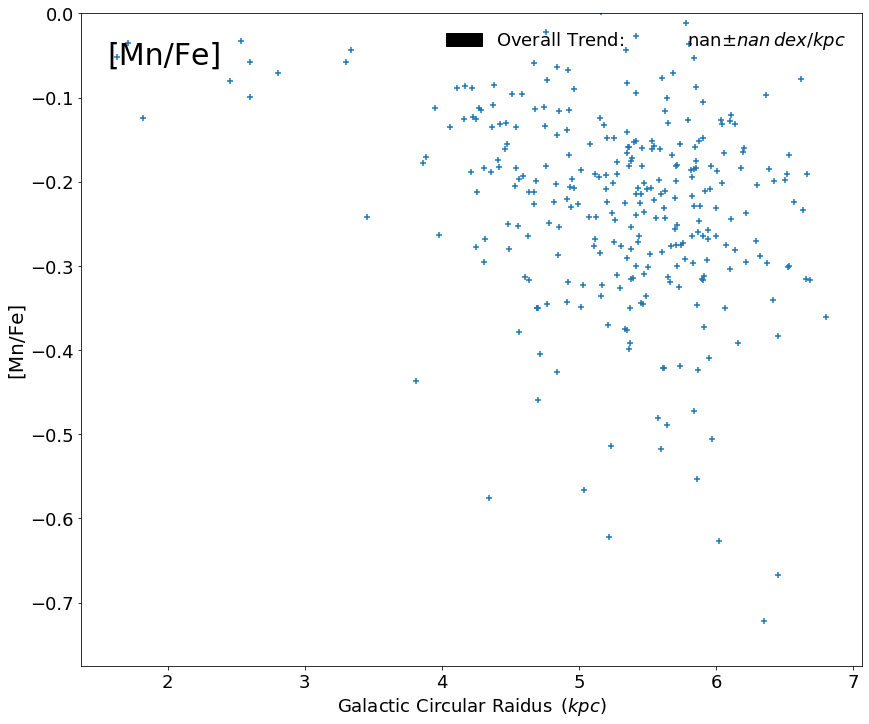

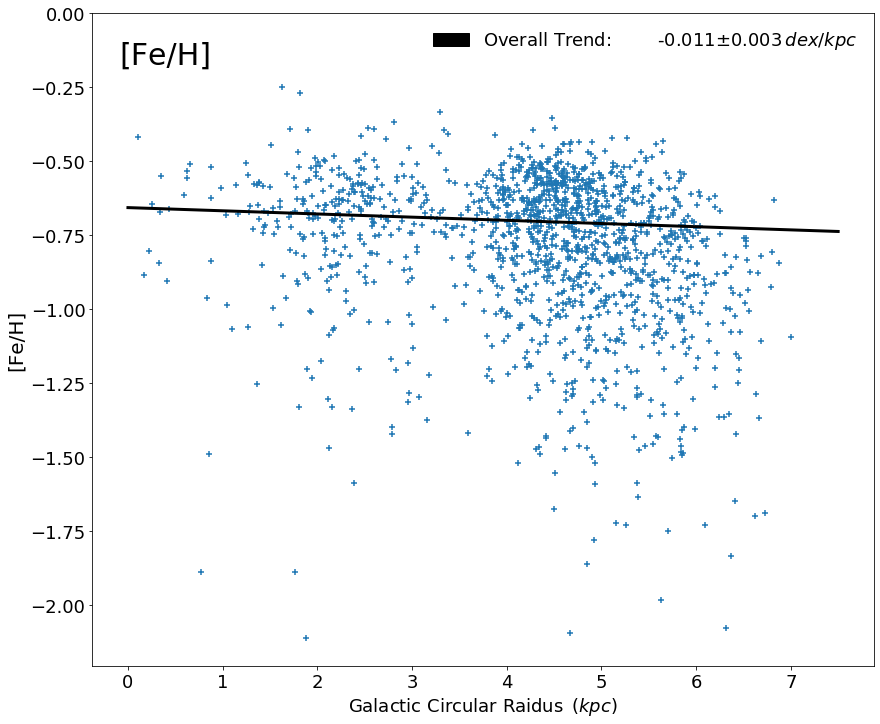

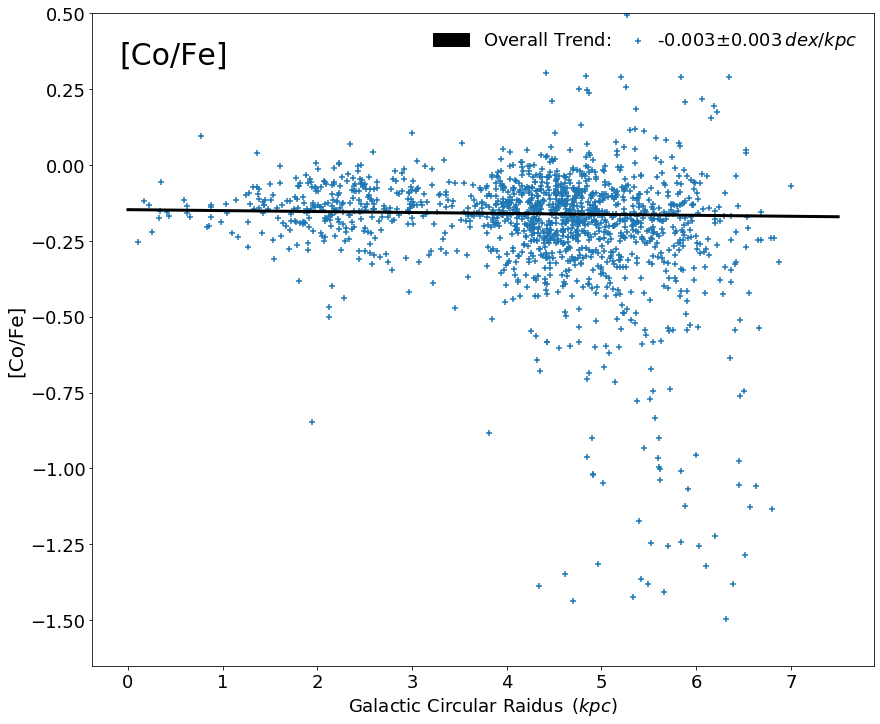

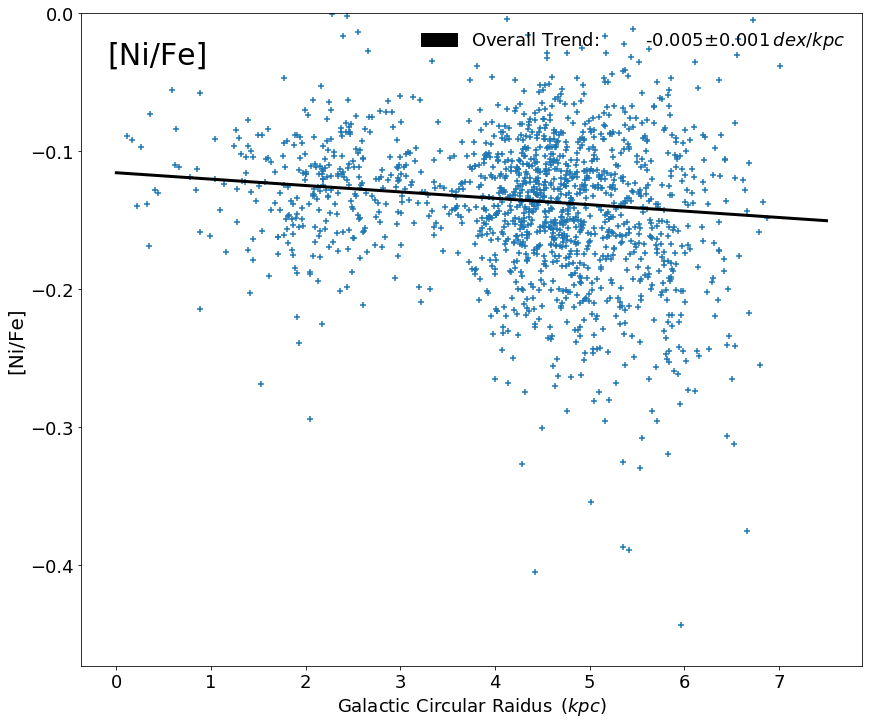

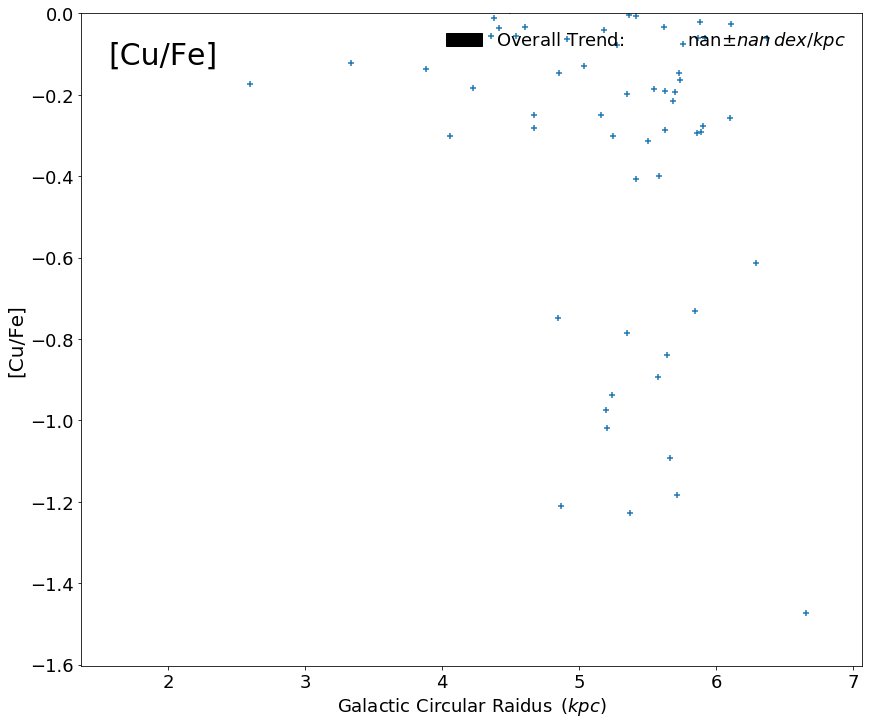

In [19]:
#####################################
### Overall Trend Plots with Data ###
#####################################

matplotlib.rcParams.update({'font.size': 18})

ytops = [0,0.1,0.7,0.2,1.0,0.4,0,0.325,2.0,0.8,0.8,0.3,0,0,0.75,0.4,0,0.0,0.5,0.0,0,0,0,0,0,0]

for i in tqdm_notebook(range(len(elems)-5),desc='plots',leave=False):
    
    cln = np.where(r13_nobloop_noagb[elems[i]]>-100)
    
    xval = np.linspace(0.0,7.5)

    fig = plt.figure(figsize=[14,12])
    
    ###Overall Trend
    def trendline(x):
        return re_med_ms[i]*x+re_med_bs[i]
    
    plt.plot(xval,trendline(xval),c='k',lw=3.0)
    plt.scatter(np.asarray(radius)[cln],r13_nobloop_noagb[elems[i]][cln],marker='+',c='tab:blue')
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    handles.append(empty_over)

    labels.append('Overall Trend: {:>13.3f}$\pm {:.3f} \,dex/kpc$'.format(re_med_ms[i],med_m_devs[i]))
    
    plt.legend(handles,labels,loc='upper right',fontsize='medium',frameon=False)

    plt.ylabel(r'{}'.format(labs[i]),fontsize=20)
    plt.xlabel(r'Galactic Circular Raidus $\,(kpc$)')
    
    plt.ylim(top = ytops[i])
    
    
    ax0 = fig.add_subplot(111)
    at0 = AnchoredText('{}'.format(labs[i]),prop=dict(size=30),frameon=False,loc='upper left')
    at0.patch.set_boxstyle("square")
    ax0.add_artist(at0)
    
#     plt.savefig('overallgradonly{}.pdf'.format(elems[i]),bbox_inches='tight')
    plt.show()

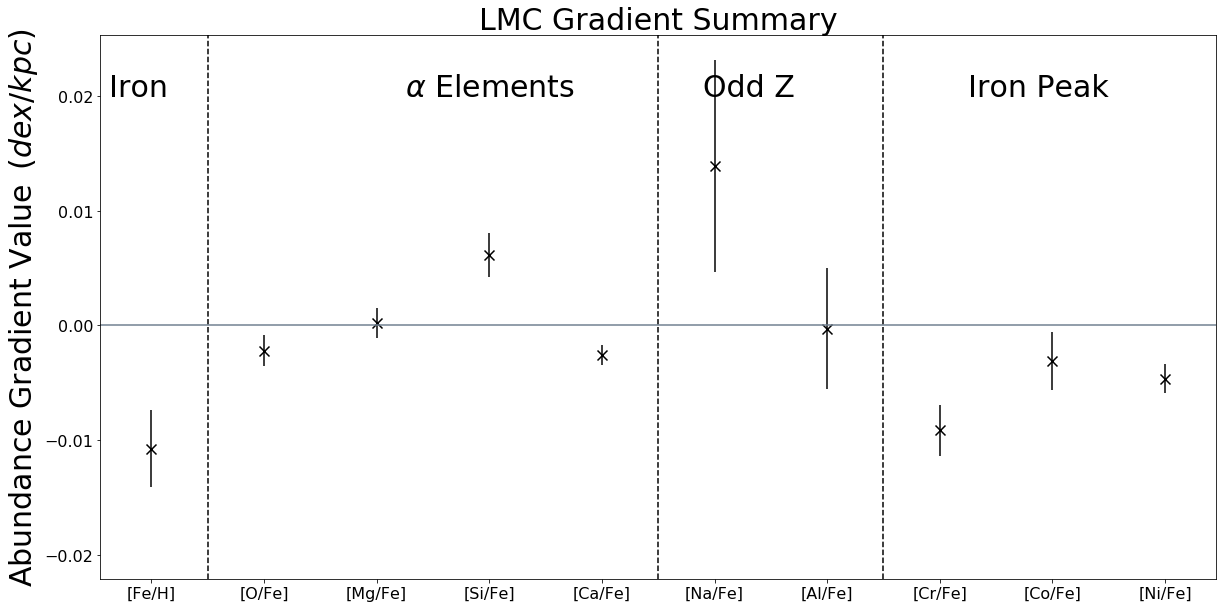

In [22]:
idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
       np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]

good_over = []
err_over = []

good_med = []
err_med = []

for i in idx:
    good_over.append(re_med_ms[i])
    err_over.append(med_m_devs[i])
    
#     good_med.append(med_m[i])

matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=[20,10])

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='x',c='black',label='Overall',s=100)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

#plt.scatter([0,1,2,3,4,5,6,7,8,9],good_med,marker='x',c='red',label='0.5 kpc bins',s=100)

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]','[Ni/Fe]']
xplotpos = [0,1,2,3,4,5,6,7,8,9] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$',fontsize=30)

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.021,'Iron',fontsize=30)
plt.text(2.25,0.021,'$\\alpha$ Elements',fontsize=30)
plt.text(4.9,0.021,'Odd Z',fontsize=30)
plt.text(7.25,0.021,'Iron Peak',fontsize=30)

plt.title(r'LMC Gradient Summary',fontsize=30)

# plt.legend(loc='lower center',frameon=True,fancybox=False,fontsize='large')
# plt.savefig('mle_overall.pdf',bbox_inches='tight')
plt.show()

# Age Bins

In [23]:
# Ages
# ages = fits.getdata('pca_ols_ages.fits')
ages = fits.getdata('TEST_pca_ols_ages.fits')[bloop_cut][agb_cut]

#####################
### Make Age Bins ###
#####################

young = np.where(ages['AGE']<=np.log10(0.5*10**9))
yless = np.where((ages['AGE']>np.log10(0.5*10**9))&(ages['AGE']<=np.log10(2.0*10**9)))
ymed = np.where((ages['AGE']>np.log10(2.0*10**9))&(ages['AGE']<=np.log10(7*10**9)))
omed = np.where((ages['AGE']>np.log10(7*10**9))&(ages['AGE']<=np.log10(10.5*10**9)))
old = np.where(ages['AGE']>np.log10(10.5*10**9))

r13young = r13[young]
r13yless = r13[yless]
r13ymed = r13[ymed]
r13omed = r13[omed]
r13old = r13[old]

In [24]:
# plt.figure(figsize=[12,10])
# plt.scatter(10**parsec['logTe'],parsec['logg'],c=parsec['MH'],cmap='jet')
# plt.colorbar()

# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()

# plt.title(r'Color as [Fe/H]')
# plt.xlabel(r'$T_{eff}$ [K]')
# plt.ylabel(r'log(g)')
# plt.show()

In [25]:
##################################
### Age bin initial Trendlines ###
##################################

### young

young_ms = []
young_bs = []

r13young = r13_nobloop_noagb[young]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13young[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[young][cln],r13young[elems[i]][cln],r13young[elems_err[i]][cln])
        young_ms.append(slope)
        young_bs.append(inter)
        
    except:
        young_ms.append(-9999.0)
        young_bs.append(-9999.0)
    
### yless

yless_ms = []
yless_bs = []

r13yless = r13_nobloop_noagb[yless]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13yless[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[yless][cln],r13yless[elems[i]][cln],r13yless[elems_err[i]][cln])
        yless_ms.append(slope)
        yless_bs.append(inter)
        
    except:
        yless_ms.append(-9999.0)
        yless_bs.append(-9999.0)
    
### ymed

ymed_ms = []
ymed_bs = []

r13ymed = r13_nobloop_noagb[ymed]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13ymed[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[ymed][cln],r13ymed[elems[i]][cln],r13ymed[elems_err[i]][cln])
        ymed_ms.append(slope)
        ymed_bs.append(inter)
        
    except:
        ymed_ms.append(-9999.0)
        ymed_bs.append(-9999.0)
    
### omed

omed_ms = []
omed_bs = []

r13omed = r13_nobloop_noagb[omed]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13omed[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[omed][cln],r13omed[elems[i]][cln],r13omed[elems_err[i]][cln])
        omed_ms.append(slope)
        omed_bs.append(inter)
        
    except:
        omed_ms.append(-9999.0)
        omed_bs.append(-9999.0)
    
### old

old_ms = []
old_bs = []

r13old = r13_nobloop_noagb[old]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13old[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle.mle_fit(radius[old][cln],r13old[elems[i]][cln],r13old[elems_err[i]][cln])
        old_ms.append(slope)
        old_bs.append(inter)
        
    except:
        old_ms.append(-9999.0)
        old_bs.append(-9999.0)

In [26]:
############################################
### Find distances between data and fits ###
############################################

young_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return young_ms[i]*x+young_bs[i]
    
    cln = np.where((r13young[elems[i]]>-100))
    plug = trendline(radius[young][cln])
    dist = plug-r13young[elems[i]][cln]
    
    young_dist.append(dist) 
    
yless_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return yless_ms[i]*x+yless_bs[i]
    
    cln = np.where((r13yless[elems[i]]>-100))
    plug = trendline(radius[yless][cln])
    dist = plug-r13yless[elems[i]][cln]
    
    yless_dist.append(dist) 
    
ymed_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return ymed_ms[i]*x+ymed_bs[i]
    
    cln = np.where((r13ymed[elems[i]]>-100))
    plug = trendline(radius[ymed][cln])
    dist = plug-r13ymed[elems[i]][cln]
    
    ymed_dist.append(dist) 
    
omed_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return omed_ms[i]*x+omed_bs[i]
    
    cln = np.where((r13omed[elems[i]]>-100))
    plug = trendline(radius[omed][cln])
    dist = plug-r13omed[elems[i]][cln]
    
    omed_dist.append(dist) 
    
old_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return old_ms[i]*x+old_bs[i]
    
    cln = np.where((r13old[elems[i]]>-100))
    plug = trendline(radius[old][cln])
    dist = plug-r13old[elems[i]][cln]
    
    old_dist.append(dist)

In [27]:
###################
### Prune Refit ###
###################

prune_fact = 3.0

re_young_ms = []
re_young_bs = []
young_m_devs = []
young_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((r13young[elems[i]]>-100))
    prune = np.where((r13young[elems[i]]>-prune_fact*util.mad(young_dist[i])+
                      np.median(r13young[cln][elems[i]]))&
                     (r13young[elems[i]]<prune_fact*util.mad(young_dist[i])+
                      np.median(r13young[cln][elems[i]])))

    exog = radius[young][prune]
    endog = r13young[elems[i]][prune]
    endog_err = r13young[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    young_m_devs.append(util.mad(slps))
    young_b_devs.append(util.mad(ints))
    re_young_ms.append(np.median(slps))
    re_young_bs.append(np.median(ints))

re_yless_ms = []
re_yless_bs = []
yless_m_devs = []
yless_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((r13yless[elems[i]]>-100))
    prune = np.where((r13yless[elems[i]]>-prune_fact*util.mad(yless_dist[i])+
                      np.median(r13yless[cln][elems[i]]))&
                     (r13yless[elems[i]]<prune_fact*util.mad(yless_dist[i])+
                      np.median(r13yless[cln][elems[i]])))

    exog = radius[yless][prune]
    endog = r13yless[elems[i]][prune]
    endog_err = r13yless[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    yless_m_devs.append(util.mad(slps))
    yless_b_devs.append(util.mad(ints))
    re_yless_ms.append(np.median(slps))
    re_yless_bs.append(np.median(ints))

re_ymed_ms = []
re_ymed_bs = []
ymed_m_devs = []
ymed_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((r13ymed[elems[i]]>-100))
    prune = np.where((r13ymed[elems[i]]>-prune_fact*util.mad(ymed_dist[i])+
                      np.median(r13ymed[cln][elems[i]]))&
                     (r13ymed[elems[i]]<prune_fact*util.mad(ymed_dist[i])+
                      np.median(r13ymed[cln][elems[i]])))

    exog = radius[ymed][prune]
    endog = r13ymed[elems[i]][prune]
    endog_err = r13ymed[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    ymed_m_devs.append(util.mad(slps))
    ymed_b_devs.append(util.mad(ints))
    re_ymed_ms.append(np.median(slps))
    re_ymed_bs.append(np.median(ints))

re_omed_ms = []
re_omed_bs = []
omed_m_devs = []
omed_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((r13omed[elems[i]]>-100))
    prune = np.where((r13omed[elems[i]]>-prune_fact*util.mad(omed_dist[i])+
                      np.median(r13omed[cln][elems[i]]))&
                     (r13omed[elems[i]]<prune_fact*util.mad(omed_dist[i])+
                      np.median(r13omed[cln][elems[i]])))

    exog = radius[omed][prune]
    endog = r13omed[elems[i]][prune]
    endog_err = r13omed[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    omed_m_devs.append(util.mad(slps))
    omed_b_devs.append(util.mad(ints))
    re_omed_ms.append(np.median(slps))
    re_omed_bs.append(np.median(ints))
    
re_old_ms = []
re_old_bs = []
old_m_devs = []
old_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((r13old[elems[i]]>-100))
    prune = np.where((r13old[elems[i]]>-prune_fact*util.mad(old_dist[i])+
                      np.median(r13old[cln][elems[i]]))&
                     (r13old[elems[i]]<prune_fact*util.mad(old_dist[i])+
                      np.median(r13old[cln][elems[i]])))

    exog = radius[old][prune]
    endog = r13old[elems[i]][prune]
    endog_err = r13old[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle.mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    old_m_devs.append(util.mad(slps))
    old_b_devs.append(util.mad(ints))
    re_old_ms.append(np.median(slps))
    re_old_bs.append(np.median(ints))

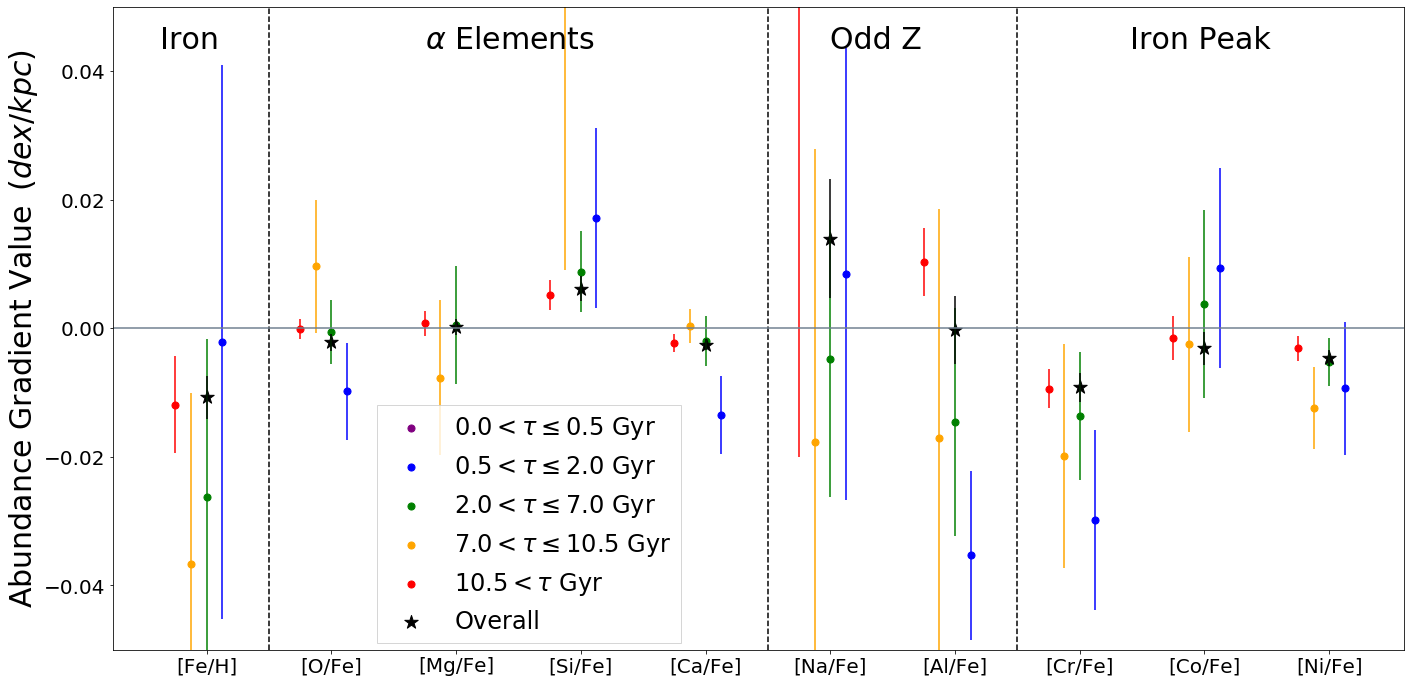

In [28]:
####################
### Summary plot ###
####################

# elements: O, Na, Mg, Al, Si, Ca, Cr, Fe, Co, Ni, V

idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
       np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]#,
       #np.squeeze(np.where(np.asarray(elems)=='V_FE'))]

good_young = []
good_yless = []
good_ymed = []
good_omed = []
good_old = []
good_over = []

err_young = []
err_yless = []
err_ymed = []
err_omed = []
err_old = []
err_over = []

for i in idx:
    good_young.append(re_young_ms[i])
    good_yless.append(re_yless_ms[i])
    good_ymed.append(re_ymed_ms[i])
    good_omed.append(re_omed_ms[i])
    good_old.append(re_old_ms[i])
    good_over.append(re_med_ms[i])
    
    err_young.append(young_m_devs[i])
    err_yless.append(yless_m_devs[i])
    err_ymed.append(ymed_m_devs[i])
    err_omed.append(omed_m_devs[i])
    err_old.append(old_m_devs[i])
    err_over.append(med_m_devs[i])

matplotlib.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=[20,10])

plt.scatter(np.add(np.arange(10),0.25),good_young,c='purple',label='$0.0 < \\tau \leq 0.5$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.25),good_young,yerr=err_young,c='purple',ls='none')

plt.scatter(np.add(np.arange(10),0.125),good_yless,c='blue',label='$0.5 < \\tau \leq 2.0$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.125),good_yless,yerr=err_yless,c='blue',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_ymed,c='green',label='$2.0 < \\tau \leq 7.0$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_ymed,yerr=err_ymed,c='green',ls='none')

plt.scatter(np.subtract(np.arange(10),0.125),good_omed,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.125),good_omed,yerr=err_omed,c='orange',ls='none')

plt.scatter(np.subtract(np.arange(10),0.25),good_old,c='red',label='$10.5 < \\tau $ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.25),good_old,yerr=err_old,c='red',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='*',c='black',label='Overall',s=200)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']#,'[V/Fe]']

xplotpos = [0,1,2,3,4,5,6,7,8,9]#,10] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$',fontsize=30)

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.0435,'Iron',fontsize=30)
plt.text(1.75,0.0435,'$\\alpha$ Elements',fontsize=30)
plt.text(5.0,0.0435,'Odd Z',fontsize=30)
plt.text(7.4,0.0435,'Iron Peak',fontsize=30)

# plt.ylim(bottom=-0.045)
plt.ylim(-0.05,0.05)

plt.legend(loc=(0.205,0.01),frameon=True,fancybox=False,fontsize='large')
plt.tight_layout()
# plt.savefig('gradientSummaryplot.pdf',bbox_inches='tight')
plt.show()

In [29]:
len(r13_nobloop_noagb)

1459

In [ ]:
### OVERALL
overallgradcat = Table()
overallgradcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
overallgradcol_stats = Column(np.asarray(re_med_ms),name='GRAD')
overallgradcol_edges = Column(np.asarray(med_m_devs),name='GRAD_ERR')
overallgradcol_number = Column(np.asarray(re_med_bs),name='INTER')
overallgradcol_spread = Column(np.asarray(med_b_devs),name='INTER_ERR')

overallgradcat.add_column(overallgradcol_elems)
overallgradcat.add_column(overallgradcol_stats)
overallgradcat.add_column(overallgradcol_edges)
overallgradcat.add_column(overallgradcol_number)
overallgradcat.add_column(overallgradcol_spread)

# overallgradcat.write('overallgrads.fits',format='fits')#,overwrite=True)

### young
younggradcat = Table()
younggradcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
younggradcol_stats = Column(np.asarray(re_young_ms),name='GRAD')
younggradcol_edges = Column(np.asarray(young_m_devs),name='GRAD_ERR')
younggradcol_number = Column(np.asarray(re_young_bs),name='INTER')
younggradcol_spread = Column(np.asarray(young_b_devs),name='INTER_ERR')

younggradcat.add_column(younggradcol_elems)
younggradcat.add_column(younggradcol_stats)
younggradcat.add_column(younggradcol_edges)
younggradcat.add_column(younggradcol_number)
younggradcat.add_column(younggradcol_spread)

# younggradcat.write('younggrads.fits',format='fits'#,overwrite=True)

### yless
ylessgradcat = Table()
ylessgradcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
ylessgradcol_stats = Column(np.asarray(re_yless_ms),name='GRAD')
ylessgradcol_edges = Column(np.asarray(yless_m_devs),name='GRAD_ERR')
ylessgradcol_number = Column(np.asarray(re_yless_bs),name='INTER')
ylessgradcol_spread = Column(np.asarray(yless_b_devs),name='INTER_ERR')

ylessgradcat.add_column(ylessgradcol_elems)
ylessgradcat.add_column(ylessgradcol_stats)
ylessgradcat.add_column(ylessgradcol_edges)
ylessgradcat.add_column(ylessgradcol_number)
ylessgradcat.add_column(ylessgradcol_spread)

# ylessgradcat.write('ylessgrads.fits',format='fits'#,overwrite=True)

### ymed
ymedgradcat = Table()
ymedgradcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
ymedgradcol_stats = Column(np.asarray(re_ymed_ms),name='GRAD')
ymedgradcol_edges = Column(np.asarray(ymed_m_devs),name='GRAD_ERR')
ymedgradcol_number = Column(np.asarray(re_ymed_bs),name='INTER')
ymedgradcol_spread = Column(np.asarray(ymed_b_devs),name='INTER_ERR')

ymedgradcat.add_column(ymedgradcol_elems)
ymedgradcat.add_column(ymedgradcol_stats)
ymedgradcat.add_column(ymedgradcol_edges)
ymedgradcat.add_column(ymedgradcol_number)
ymedgradcat.add_column(ymedgradcol_spread)

# ymedgradcat.write('ymedgrads.fits',format='fits'#,overwrite=True)

### omed
omedgradcat = Table()
omedgradcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
omedgradcol_stats = Column(np.asarray(re_omed_ms),name='GRAD')
omedgradcol_edges = Column(np.asarray(omed_m_devs),name='GRAD_ERR')
omedgradcol_number = Column(np.asarray(re_omed_bs),name='INTER')
omedgradcol_spread = Column(np.asarray(omed_b_devs),name='INTER_ERR')

omedgradcat.add_column(omedgradcol_elems)
omedgradcat.add_column(omedgradcol_stats)
omedgradcat.add_column(omedgradcol_edges)
omedgradcat.add_column(omedgradcol_number)
omedgradcat.add_column(omedgradcol_spread)

# omedgradcat.write('omedgrads.fits',format='fits'#,overwrite=True)

### old
oldgradcat = Table()
oldgradcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
oldgradcol_stats = Column(np.asarray(re_old_ms),name='GRAD')
oldgradcol_edges = Column(np.asarray(old_m_devs),name='GRAD_ERR')
oldgradcol_number = Column(np.asarray(re_old_bs),name='INTER')
oldgradcol_spread = Column(np.asarray(old_b_devs),name='INTER_ERR')

oldgradcat.add_column(oldgradcol_elems)
oldgradcat.add_column(oldgradcol_stats)
oldgradcat.add_column(oldgradcol_edges)
oldgradcat.add_column(oldgradcol_number)
oldgradcat.add_column(oldgradcol_spread)

# oldgradcat.write('oldgrads.fits',format='fits'#,overwrite=True)

In [ ]:
test = fits.getdata('younggrads.fits')
test['GRAD'] == np.asarray(re_young_ms)

In [ ]:
prune_fact = 3.0

radiusyoung = radius[young]
radiusyless = radius[yless]
radiusymed = radius[ymed]
radiusomed = radius[omed]
radiusold = radius[old]

### young
young_stats = [] 
young_edges = []
young_number = []
young_spread = []

for i in range(len(elems)-5):
    cln = np.where(r13young[elems[i]]>-100.)
    young_cln = np.where((r13young[elems[i]]>-prune_fact*util.mad(young_dist[i])+
                          np.median(r13young[cln][elems[i]]))&
                         (r13young[elems[i]]<prune_fact*util.mad(young_dist[i])+
                          np.median(r13young[cln][elems[i]])))
    try:
        bins = np.arange(np.floor(np.min(radiusyoung[young_cln])),np.ceil(np.max(radiusyoung[young_cln])),1)
        young_bin_stats, young_bin_edges, young_binnumber = binned_statistic(radiusyoung[young_cln],
                                                                             r13young[elems[i]][young_cln],
                                                                             statistic='median',bins=bins)
        young_mad, _, _ = binned_statistic(radiusyoung[young_cln],r13young[elems[i]][young_cln],
                                                 statistic=lambda y: util.mad(y),bins=bins)
                                                                        
        young_stats.append(young_bin_stats)
        young_edges.append(young_bin_edges)
        young_number.append(young_binnumber)
        young_spread.append(young_mad)
        
    
    except:
            young_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            young_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            young_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            young_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))

        
### yless
yless_stats = [] 
yless_edges = []
yless_number = []
yless_spread = []

for i in range(len(elems)-5):
    cln = np.where(r13yless[elems[i]]>-100.)
    yless_cln = np.where((r13yless[elems[i]]>-prune_fact*util.mad(yless_dist[i])+
                          np.median(r13yless[cln][elems[i]]))&
                         (r13yless[elems[i]]<prune_fact*util.mad(yless_dist[i])+
                          np.median(r13yless[cln][elems[i]])))
    try:
        bins = np.arange(np.floor(np.min(radiusyless[yless_cln])),np.ceil(np.max(radiusyless[yless_cln])),1)
        yless_bin_stats, yless_bin_edges, yless_binnumber = binned_statistic(radiusyless[yless_cln],
                                                                             r13yless[elems[i]][yless_cln],
                                                                             statistic='median',bins=bins)
        yless_mad, _, _ = binned_statistic(radiusyless[yless_cln],r13yless[elems[i]][yless_cln],
                                                 statistic=lambda y: util.mad(y),bins=bins)
                                                                        
        yless_stats.append(yless_bin_stats)
        yless_edges.append(yless_bin_edges)
        yless_number.append(yless_binnumber)
        yless_spread.append(yless_mad)
        
    
    except:
            yless_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            yless_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            yless_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            yless_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
### ymed
ymed_stats = [] 
ymed_edges = []
ymed_number = []
ymed_spread = []

for i in range(len(elems)-5):
    cln = np.where(r13ymed[elems[i]]>-100.)
    ymed_cln = np.where((r13ymed[elems[i]]>-prune_fact*util.mad(ymed_dist[i])+
                          np.median(r13ymed[cln][elems[i]]))&
                         (r13ymed[elems[i]]<prune_fact*util.mad(ymed_dist[i])+
                          np.median(r13ymed[cln][elems[i]])))
    try:
        bins = np.arange(np.floor(np.min(radiusymed[ymed_cln])),np.ceil(np.max(radiusymed[ymed_cln])),1)
        ymed_bin_stats, ymed_bin_edges, ymed_binnumber = binned_statistic(radiusymed[ymed_cln],
                                                                             r13ymed[elems[i]][ymed_cln],
                                                                             statistic='median',bins=bins)
        ymed_mad, _, _ = binned_statistic(radiusymed[ymed_cln],r13ymed[elems[i]][ymed_cln],
                                                 statistic=lambda y: util.mad(y),bins=bins)
                                                                        
        ymed_stats.append(ymed_bin_stats)
        ymed_edges.append(ymed_bin_edges)
        ymed_number.append(ymed_binnumber)
        ymed_spread.append(ymed_mad)
        
    
    except:
            ymed_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            ymed_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            ymed_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            ymed_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
### omed
omed_stats = [] 
omed_edges = []
omed_number = []
omed_spread = []

for i in range(len(elems)-5):
    cln = np.where(r13omed[elems[i]]>-100.)
    omed_cln = np.where((r13omed[elems[i]]>-prune_fact*util.mad(omed_dist[i])+
                          np.median(r13omed[cln][elems[i]]))&
                         (r13omed[elems[i]]<prune_fact*util.mad(omed_dist[i])+
                          np.median(r13omed[cln][elems[i]])))
    try:
        bins = np.arange(np.floor(np.min(radiusomed[omed_cln])),np.ceil(np.max(radiusomed[omed_cln])),1)
        omed_bin_stats, omed_bin_edges, omed_binnumber = binned_statistic(radiusomed[omed_cln],
                                                                             r13omed[elems[i]][omed_cln],
                                                                             statistic='median',bins=bins)
        omed_mad, _, _ = binned_statistic(radiusomed[omed_cln],r13omed[elems[i]][omed_cln],
                                                 statistic=lambda y: util.mad(y),bins=bins)
                                                                        
        omed_stats.append(omed_bin_stats)
        omed_edges.append(omed_bin_edges)
        omed_number.append(omed_binnumber)
        omed_spread.append(omed_mad)
        
    
    except:
            omed_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            omed_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            omed_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            omed_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
### old
old_stats = [] 
old_edges = []
old_number = []
old_spread = []

for i in range(len(elems)-5):
    cln = np.where(r13old[elems[i]]>-100.)
    old_cln = np.where((r13old[elems[i]]>-prune_fact*util.mad(old_dist[i])+
                          np.median(r13old[cln][elems[i]]))&
                         (r13old[elems[i]]<prune_fact*util.mad(old_dist[i])+
                          np.median(r13old[cln][elems[i]])))
    try:
        bins = np.arange(np.floor(np.min(radiusold[old_cln])),np.ceil(np.max(radiusold[old_cln])),1)
        old_bin_stats, old_bin_edges, old_binnumber = binned_statistic(radiusold[old_cln],
                                                                             r13old[elems[i]][old_cln],
                                                                             statistic='median',bins=bins)
        old_mad, _, _ = binned_statistic(radiusold[old_cln],r13old[elems[i]][old_cln],
                                                 statistic=lambda y: util.mad(y),bins=bins)
                                                                        
        old_stats.append(old_bin_stats)
        old_edges.append(old_bin_edges)
        old_number.append(old_binnumber)
        old_spread.append(old_mad)
        
    
    except:
            old_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            old_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            old_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            old_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))

In [ ]:
ylesstrendcat

In [ ]:
### YOUNG
cp_young_stats = np.copy(young_stats).tolist()
cp_young_spread = np.copy(young_spread).tolist()

for i in range(len(cp_young_stats)):
    if len(cp_young_stats[i])<6:
        cp_young_stats[i] = np.append(cp_young_stats[i],-9999.0*np.ones(6-len(cp_young_stats[i])))
        cp_young_spread[i] = np.append(cp_young_spread[i],-9999.0*np.ones(6-len(cp_young_spread[i])))
        
youngtrendcat = Table()
youngtrendcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe_','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
youngtrendcol_stats = Column(np.squeeze(np.asarray(cp_young_stats)),name='STATS')
youngtrendcol_spread = Column(np.asarray(cp_young_spread),name='SPREAD')

youngtrendcat.add_column(youngtrendcol_elems)
youngtrendcat.add_column(youngtrendcol_stats)
youngtrendcat.add_column(youngtrendcol_spread)

youngtrendcat.write('youngtrends.fits')#,overwrite=True)

### yless
cp_yless_stats = np.copy(yless_stats).tolist()
cp_yless_spread = np.copy(yless_spread).tolist()

for i in range(len(cp_yless_stats)):
    if len(cp_yless_stats[i])<7:
        cp_yless_stats[i] = np.append(cp_yless_stats[i],-9999.0*np.ones(7-len(cp_yless_stats[i])))
        cp_yless_spread[i] = np.append(cp_yless_spread[i],-9999.0*np.ones(7-len(cp_yless_spread[i])))
        
ylesstrendcat = Table()
ylesstrendcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe_','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
ylesstrendcol_stats = Column(np.squeeze(np.asarray(cp_yless_stats)),name='STATS')
ylesstrendcol_spread = Column(np.asarray(cp_yless_spread),name='SPREAD')

ylesstrendcat.add_column(ylesstrendcol_elems)
ylesstrendcat.add_column(ylesstrendcol_stats)
ylesstrendcat.add_column(ylesstrendcol_spread)

ylesstrendcat.write('ylesstrends.fits')#,overwrite=True)

### YMED
cp_ymed_stats = np.copy(ymed_stats).tolist()
cp_ymed_spread  = np.copy(ymed_spread).tolist()

for i in range(len(cp_ymed_stats)):
    if len(cp_ymed_stats[i])<6:
        cp_ymed_stats[i] = np.append(cp_ymed_stats[i],-9999.0*np.ones(6-len(cp_ymed_stats[i])))
        cp_ymed_spread[i] = np.append(cp_ymed_spread[i],-9999.0*np.ones(6-len(cp_ymed_spread[i])))
        
ymedtrendcat = Table()
ymedtrendcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe_','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
ymedtrendcol_stats = Column(np.squeeze(np.asarray(cp_ymed_stats)),name='STATS')
ymedtrendcol_spread = Column(np.asarray(cp_ymed_spread),name='SPREAD')

ymedtrendcat.add_column(ymedtrendcol_elems)
ymedtrendcat.add_column(ymedtrendcol_stats)
ymedtrendcat.add_column(ymedtrendcol_spread)

ymedtrendcat.write('ymedtrends.fits')#,overwrite=True)

### OMED
cp_omed_stats = np.copy(omed_stats).tolist()
cp_omed_spread  = np.copy(omed_spread).tolist()

for i in range(len(cp_omed_stats)):
    if len(cp_omed_stats[i])<6:
        cp_omed_stats[i] = np.append(cp_omed_stats[i],-9999.0*np.ones(6-len(cp_omed_stats[i])))
        cp_omed_spread[i] = np.append(cp_omed_spread[i],-9999.0*np.ones(6-len(cp_omed_spread[i])))
        
omedtrendcat = Table()
omedtrendcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe_','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
omedtrendcol_stats = Column(np.squeeze(np.asarray(cp_omed_stats)),name='STATS')
omedtrendcol_spread = Column(np.asarray(cp_omed_spread),name='SPREAD')

omedtrendcat.add_column(omedtrendcol_elems)
omedtrendcat.add_column(omedtrendcol_stats)
omedtrendcat.add_column(omedtrendcol_spread)

omedtrendcat.write('omedtrends.fits')#,overwrite=True)

### OLD
cp_old_stats = np.copy(old_stats).tolist()
cp_old_spread  = np.copy(old_spread).tolist()

for i in range(len(cp_old_stats)):
    if len(cp_old_stats[i])<6:
        cp_old_stats[i] = np.append(cp_old_stats[i],-9999.0*np.ones(6-len(cp_old_stats[i])))
        cp_old_spread[i] = np.append(cp_old_spread[i],-9999.0*np.ones(6-len(cp_old_spread[i])))
        
oldtrendcat = Table()
oldtrendcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe_','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
oldtrendcol_stats = Column(np.squeeze(np.asarray(cp_old_stats)),name='STATS')
oldtrendcol_spread = Column(np.asarray(cp_old_spread),name='SPREAD')

oldtrendcat.add_column(oldtrendcol_elems)
oldtrendcat.add_column(oldtrendcol_stats)
oldtrendcat.add_column(oldtrendcol_spread)

oldtrendcat.write('oldtrends.fits')#,overwrite=True)

In [ ]:
labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/FE]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge_Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']
els = ['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe','K_Fe','Ca_Fe','Ti_Fe',
       'TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe','Ge_Fe','Rb_Fe','Ce_Fe','Nd_Fe','Yb_Fe']

ytops = [0,0.1,0.7,0.2,1.0,0.4,0,0.325,2.0,0.8,0.8,0.3,0,0,0.75,0.4,0,0.0,0.5,0.0,0,0,0,0,0,0]

matplotlib.rcParams.update({'font.size': 30})
import matplotlib.patches as mpatches

young_parage = np.asarray(ages)[young]
yless_parage = np.asarray(ages)[yless]
ymed_parage = np.asarray(ages)[ymed]
omed_parage = np.asarray(ages)[omed]
old_parage = np.asarray(ages)[old]

for i in tqdm_notebook(range(len(elems)-5),desc='plots',leave=False):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return re_young_ms[i]*x+re_young_bs[i]
    def ylesstrendline(x):
        return re_yless_ms[i]*x+re_yless_bs[i]
    def ymedtrendline(x):
        return re_ymed_ms[i]*x+re_ymed_bs[i]
    def omedtrendline(x):
        return re_omed_ms[i]*x+re_omed_bs[i]
    def oldtrendline(x):
        return re_old_ms[i]*x+re_old_bs[i]
    
    young_ = np.where((r13young[elems[i]]>-100))#&(r13young['SNR']>=100))
    yless_ = np.where((r13yless[elems[i]]>-100))#&(r13yless['SNR']>=100))
    ymed_ = np.where((r13ymed[elems[i]]>-100))#&(r13ymed['SNR']>=100))
    omed_ = np.where((r13omed[elems[i]]>-100))#&(r13omed['SNR']>=100))
    old_ = np.where((r13old[elems[i]]>-100))#&(r13old['SNR']>=100))
    
    fig = plt.figure(figsize=[14,12])

#     plt.scatter(np.arange(len(young_stats[i]))+0.5+0.25,young_stats[i],color='purple',marker='o',s=100)
    plt.errorbar(np.arange(len(young_stats[i]))+0.5+0.25,young_stats[i],yerr=young_spread[i],color='purple',
                 ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(young_stats[i]))+0.5+0.25,young_stats[i],color='purple')
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
#     plt.scatter(np.arange(len(yless_stats[i]))+0.5+0.125,yless_stats[i],color='blue',marker='o',s=100)
    plt.errorbar(np.arange(len(yless_stats[i]))+0.5+0.125,yless_stats[i],yerr=yless_spread[i],color='blue',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(yless_stats[i]))+0.5+0.125,yless_stats[i],color='blue')
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
#     plt.scatter(np.arange(len(ymed_stats[i]))+0.5,ymed_stats[i],color='green',marker='o',s=100)
    plt.errorbar(np.arange(len(ymed_stats[i]))+0.5,ymed_stats[i],yerr=ymed_spread[i],color='green',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(ymed_stats[i]))+0.5,ymed_stats[i],color='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

#     plt.scatter(np.arange(len(omed_stats[i]))+0.5-0.125,omed_stats[i],color='orange',marker='o',s=100)
    plt.errorbar(np.arange(len(omed_stats[i]))+0.5-0.125,omed_stats[i],yerr=omed_spread[i],color='orange',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(omed_stats[i]))+0.5-0.125,omed_stats[i],color='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    

#     plt.scatter(np.arange(len(old_stats[i]))+0.5-0.25,old_stats[i],color='red',marker='o',s=100)
    plt.errorbar(np.arange(len(old_stats[i]))+0.5-0.25,old_stats[i],yerr=old_spread[i],color='red',ls='-',
                 alpha=0.5,lw=1)
    plt.plot(np.arange(len(old_stats[i]))+0.5-0.25,old_stats[i],color='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
    ###Overall Trend
    def trendline(x):
        return re_med_ms[i]*x+re_med_bs[i]
    plt.plot(xval,trendline(xval),c='k',lw=3.0)
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[i],
                                                                                      young_m_devs[i]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_yless_ms[i],
                                                                                      yless_m_devs[i]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_ymed_ms[i],
                                                                                      ymed_m_devs[i]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(re_omed_ms[i],
                                                                                       omed_m_devs[i]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(re_old_ms[i],
                                                                               old_m_devs[i]))
    labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(re_med_ms[i],
                                                                          med_m_devs[i]))
    
    plt.legend(handles,labels,loc='upper right',fontsize=15,frameon=False)

    plt.ylabel(r'{}'.format(labs[i]),fontsize=30)
    plt.xlabel(r'Elliptical Raidus $\,(kpc$)')
#     plt.ylim(top = ytops[i])
    
#     if elems[i] == 'CR_FE':
#         plt.ylim(bottom = -0.4)
#         plt.ylim(top = 0.3)
        
#     if elems[i] == 'MG_FE':
#         plt.ylim(0.0, 0.225)
        
#     if elems[i] == 'SI_FE':
#         plt.ylim(top = 0.2)
        
    if elems[i] == 'NA_FE':
        plt.ylim(-0.35,0.)
        
#     if elems[i] == 'O_FE':
#         plt.ylim(top = 0.150)
        
#     if elems[i] == 'CA_FE':
#         plt.ylim(top = 0.225)
        
#     if elems[i] == 'AL_FE':
#         plt.ylim(top = -0.05)
        
#     if elems[i] == 'CO_FE':
#         plt.ylim(top = 0.25)
    
    ax0 = fig.add_subplot(111)
    at0 = AnchoredText('{}'.format(labs[i]),prop=dict(size=30),frameon=False,loc='upper left')
    at0.patch.set_boxstyle("square")
    ax0.add_artist(at0)
    
#     plt.savefig('medians_age_bins_{}2.png'.format(els[i]),bbox_inches='tight')
    plt.tight_layout()
#     plt.savefig('test_thisone_medians_age_bins_{}2.pdf'.format(els[i]),bbox_inches='tight')
    plt.show()

In [ ]:
labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/FE]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge_Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']
els = ['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe','K_Fe','Ca_Fe_','Ti_Fe',
       'TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe','Ge_Fe','Rb_Fe','Ce_Fe','Nd_Fe','Yb_Fe']

ytops = [0,0.1,0.7,0.2,1.0,0.4,0,0.325,2.0,0.8,0.8,0.3,0,0,0.75,0.4,0,0.0,0.5,0.0,0,0,0,0,0,0]

ironsubs = [221,222,223,224]

matplotlib.rcParams.update({'font.size': 18})
import matplotlib.patches as mpatches

young_parage = np.asarray(ages)[young]
yless_parage = np.asarray(ages)[yless]
ymed_parage = np.asarray(ages)[ymed]
omed_parage = np.asarray(ages)[omed]
old_parage = np.asarray(ages)[old]

for i in tqdm_notebook([3,5,7,11],desc='plots',leave=False):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return re_young_ms[i]*x+re_young_bs[i]
    def ylesstrendline(x):
        return re_yless_ms[i]*x+re_yless_bs[i]
    def ymedtrendline(x):
        return re_ymed_ms[i]*x+re_ymed_bs[i]
    def omedtrendline(x):
        return re_omed_ms[i]*x+re_omed_bs[i]
    def oldtrendline(x):
        return re_old_ms[i]*x+re_old_bs[i]
    
#     if i == 3:
#         j = 0
#     if i == 5:
#         j = 1
#     if i == 7:
#         j = 2
#     if i == 11:
#         j = 3
    
#     plt.subplots(ironsubs[j])

    fig = plt.figure(figsize=[14,12])
    
    plt.errorbar(np.arange(len(young_stats[i]))+0.5+0.25,young_stats[i],yerr=young_spread[i],color='purple',
                 ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(young_stats[i]))+0.5+0.25,young_stats[i],color='purple')
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young

    
    plt.errorbar(np.arange(len(yless_stats[i]))+0.5+0.125,yless_stats[i],yerr=yless_spread[i],color='blue',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(yless_stats[i]))+0.5+0.125,yless_stats[i],color='blue')
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    

    plt.errorbar(np.arange(len(ymed_stats[i]))+0.5,ymed_stats[i],yerr=ymed_spread[i],color='green',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(ymed_stats[i]))+0.5,ymed_stats[i],color='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed


    plt.errorbar(np.arange(len(omed_stats[i]))+0.5-0.125,omed_stats[i],yerr=omed_spread[i],color='orange',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(omed_stats[i]))+0.5-0.125,omed_stats[i],color='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    

    plt.errorbar(np.arange(len(old_stats[i]))+0.5-0.25,old_stats[i],yerr=old_spread[i],color='red',ls='-',
                 alpha=0.5,lw=1)
    plt.plot(np.arange(len(old_stats[i]))+0.5-0.25,old_stats[i],color='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
    ###Overall Trend
    def trendline(x):
        return re_med_ms[i]*x+re_med_bs[i]
    plt.plot(xval,trendline(xval),c='k',lw=3.0)
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[i],
                                                                                      young_m_devs[i]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_yless_ms[i],
                                                                                      yless_m_devs[i]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_ymed_ms[i],
                                                                                      ymed_m_devs[i]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(re_omed_ms[i],
                                                                                       omed_m_devs[i]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(re_old_ms[i],
                                                                               old_m_devs[i]))
    labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(re_med_ms[i],
                                                                          med_m_devs[i]))
    
    plt.legend(handles,labels,loc='upper right',fontsize='small',frameon=False)

    plt.ylabel(r'{}'.format(labs[i]),fontsize=20)
    plt.xlabel(r'Elliptical Raidus $\,(kpc$)')

        
#     if elems[i] == 'NA_FE':
#         plt.ylim(-0.35,0.)
        
    
    ax0 = fig.add_subplot(111)
    at0 = AnchoredText('{}'.format(labs[i]),prop=dict(size=30),frameon=False,loc='upper left')
    at0.patch.set_boxstyle("square")
    ax0.add_artist(at0)
    
    plt.tight_layout()
#     plt.savefig('test_thisone_medians_age_bins_{}2.pdf'.format(els[i]),bbox_inches='tight')
    plt.show()

<font size='15'>
    <b>
        NEED TO FIND BUG BELOW HERE DON'T USE RIGHT NOW
    </b>
</font>

In [ ]:
iron = [int(np.squeeze(np.where(np.asarray(labs)=='[Fe/H]'))),
        int(np.squeeze(np.where(np.asarray(labs)=='[Cr/Fe]'))),
        int(np.squeeze(np.where(np.asarray(labs)=='[Co/Fe]'))),
        int(np.squeeze(np.where(np.asarray(labs)=='[Ni/Fe]')))]

iron_sub = [221,222,223,224]

label_y = [-0.31,0.142,0.015,-0.06]

# tops = [,,,]
bottoms = [-0.9,-0.1,-0.25,-0.19]

plt.figure(figsize=[36,30])

for i,j in enumerate(iron): #range(len(iron)):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return re_young_ms[j]*x+re_young_bs[j]
    def ylesstrendline(x):
        return re_yless_ms[j]*x+re_yless_bs[j]
    def ymedtrendline(x):
        return re_ymed_ms[j]*x+re_ymed_bs[j]
    def omedtrendline(x):
        return re_omed_ms[j]*x+re_omed_bs[j]
    def oldtrendline(x):
        return re_old_ms[j]*x+re_old_bs[j]
    def trendline(x):
        return re_med_ms[j]*x+re_med_bs[j]
    
    plt.subplot(iron_sub[i])
    
    plt.errorbar(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],yerr=young_spread[j],color='purple',
                 ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],color='purple')
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
    plt.errorbar(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],yerr=yless_spread[j],color='blue',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],color='blue')
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
    plt.errorbar(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],yerr=ymed_spread[j],color='green',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],color='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

    plt.errorbar(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],yerr=omed_spread[j],color='orange',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],color='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    
    plt.errorbar(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],yerr=old_spread[j],color='red',ls='-',
                 alpha=0.5,lw=1)
    plt.plot(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],color='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
    plt.plot(xval,trendline(xval),c='k',lw=3.0) #overall
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
                                                                                      young_m_devs[j]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_yless_ms[j],
                                                                                      yless_m_devs[j]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_ymed_ms[j],
                                                                                      ymed_m_devs[j]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(re_omed_ms[j],
                                                                                       omed_m_devs[j]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
                                                                               old_m_devs[j]))
    labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(re_med_ms[j],
                                                                          med_m_devs[j]))
    
    plt.legend(handles,labels,loc='upper right',fontsize='large',frameon=False)
    
    plt.text(0,label_y[i],'{}'.format(labs[j]),fontsize=50)

    plt.ylim(bottom = bottoms[i])
    
    if labs[i] == 'CR_FE':
        plt.ylim(top = -0.06)

    plt.ylabel(r'{}'.format(labs[j]),fontsize=30)
    plt.xlabel(r'Raidus $\,(kpc$)',fontsize=30)
    
plt.tight_layout()
plt.savefig('test_thisone_ironpeaks.pdf',bbox_inches='tight')
plt.show()

In [ ]:
# iron = [int(np.squeeze(np.where(np.asarray(labs)=='[Fe/H]'))),
#         int(np.squeeze(np.where(np.asarray(labs)=='[Cr/Fe]'))),
#         int(np.squeeze(np.where(np.asarray(labs)=='[Co/Fe]'))),
#         int(np.squeeze(np.where(np.asarray(labs)=='[Ni/Fe]')))]

# iron_sub = [221,222,223,224]

# label_y = [-0.31,0.142,0.015,-0.06]

# # tops = [,,,]
# bottoms = [-0.9,-0.1,-0.25,-0.19]

# plt.figure(figsize=[36,30])

# for i,j in enumerate(iron): #range(len(iron)):
#     xval = np.linspace(0.0,7.5)
    
#     def youngtrendline(x):
#         return re_young_ms[j]*x+re_young_bs[j]
#     def ylesstrendline(x):
#         return re_yless_ms[j]*x+re_yless_bs[j]
#     def ymedtrendline(x):
#         return re_ymed_ms[j]*x+re_ymed_bs[j]
#     def omedtrendline(x):
#         return re_omed_ms[j]*x+re_omed_bs[j]
#     def oldtrendline(x):
#         return re_old_ms[j]*x+re_old_bs[j]
#     def trendline(x):
#         return re_med_ms[j]*x+re_med_bs[j]
    
#     plt.subplot(iron_sub[i])
    
#     plt.errorbar(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],yerr=young_spread[j],color='purple',
#                  ls='-',alpha=0.75,lw=1)
#     plt.plot(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],color='purple')
#     plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
#     plt.errorbar(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],yerr=yless_spread[j],color='blue',
#                  ls='-',alpha=0.5,lw=1)
#     plt.plot(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],color='blue')
#     plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
#     plt.errorbar(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],yerr=ymed_spread[j],color='green',
#                  ls='-',alpha=0.5,lw=1)
#     plt.plot(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],color='green')
#     plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

#     plt.errorbar(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],yerr=omed_spread[j],color='orange',
#                  ls='-',alpha=0.5,lw=1)
#     plt.plot(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],color='orange')
#     plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    
#     plt.errorbar(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],yerr=old_spread[j],color='red',ls='-',
#                  alpha=0.5,lw=1)
#     plt.plot(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],color='red')
#     plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
#     plt.plot(xval,trendline(xval),c='k',lw=3.0) #overall
    
#     handles,labels = plt.gca().get_legend_handles_labels()
#     empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
#     empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
#     empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
#     empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
#     empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
#     empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
#     handles.append(empty_young)
#     handles.append(empty_yless)
#     handles.append(empty_ymed)
#     handles.append(empty_omed)
#     handles.append(empty_old)
#     handles.append(empty_over)
    
#     labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
#                                                                                       young_m_devs[j]))
#     labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_yless_ms[j],
#                                                                                       yless_m_devs[j]))
#     labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_ymed_ms[j],
#                                                                                       ymed_m_devs[j]))
#     labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(re_omed_ms[j],
#                                                                                        omed_m_devs[j]))
#     labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
#                                                                                old_m_devs[j]))
#     labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(re_med_ms[j],
#                                                                           med_m_devs[j]))
    
#     plt.legend(handles,labels,loc='upper right',fontsize='large',frameon=False)
    
#     plt.text(0,label_y[i],'{}'.format(labs[j]),fontsize=50)

#     plt.ylim(-0.9,0.2)

#     plt.ylabel(r'{}'.format(labs[j]),fontsize=30)
#     plt.xlabel(r'Raidus $\,(kpc$)',fontsize=30)
    
# plt.tight_layout()
# plt.show()

In [ ]:
alp = [int(np.squeeze(np.where(np.asarray(labs)=='[O/Fe]'))),
       int(np.squeeze(np.where(np.asarray(labs)=='[Mg/Fe]'))),
       int(np.squeeze(np.where(np.asarray(labs)=='[Si/Fe]'))),
       int(np.squeeze(np.where(np.asarray(labs)=='[Ca/Fe]')))]

alp_sub = [221,222,223,224]

label_y = [0.099,0.19,0.105,0.147]
bottoms = [-0.01,0.0,-0.07,0.02]
tops = [0.11,0.208,0.12,0.1575]

plt.figure(figsize=[36,30])

for i,j in enumerate([3,5,7,11]): #range(len(iron)):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return re_young_ms[j]*x+re_young_bs[j]
    def ylesstrendline(x):
        return re_yless_ms[j]*x+re_yless_bs[j]
    def ymedtrendline(x):
        return re_ymed_ms[j]*x+re_ymed_bs[j]
    def omedtrendline(x):
        return re_omed_ms[j]*x+re_omed_bs[j]
    def oldtrendline(x):
        return re_old_ms[j]*x+re_old_bs[j]
    def trendline(x):
        return re_med_ms[j]*x+re_med_bs[j]
    
    plt.subplot(alp_sub[i])
    
    plt.errorbar(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],yerr=young_spread[j],color='purple',
                 ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],color='purple')
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
    plt.errorbar(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],yerr=yless_spread[j],color='blue',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],color='blue')
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
    plt.errorbar(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],yerr=ymed_spread[j],color='green',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],color='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

    plt.errorbar(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],yerr=omed_spread[j],color='orange',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],color='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    
    plt.errorbar(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],yerr=old_spread[j],color='red',ls='-',
                 alpha=0.5,lw=1)
    plt.plot(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],color='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
    plt.plot(xval,trendline(xval),c='k',lw=3.0) #overall
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
                                                                                      young_m_devs[j]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_yless_ms[j],
                                                                                      yless_m_devs[j]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_ymed_ms[j],
                                                                                      ymed_m_devs[j]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(re_omed_ms[j],
                                                                                       omed_m_devs[j]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
                                                                               old_m_devs[j]))
    labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(re_med_ms[j],
                                                                          med_m_devs[j]))
    
    plt.legend(handles,labels,loc='upper right',fontsize='large',frameon=False)
    
    plt.text(0,label_y[i],'{}'.format(labs[j]),fontsize=50)

    plt.ylim(bottom = bottoms[i])
    plt.ylim(top = tops[i])
    
#     if labs[i] == 'CR_FE':
#         plt.ylim(top = -0.06)

    plt.ylabel(r'{}'.format(labs[j]),fontsize=30)
    plt.xlabel(r'Raidus $\,(kpc$)',fontsize=30)

plt.tight_layout()
# plt.savefig('test_thisone_alphas.pdf',bbox_inches='tight')

plt.show()

In [ ]:
# alp = [int(np.squeeze(np.where(np.asarray(labs)=='[O/Fe]'))),
#        int(np.squeeze(np.where(np.asarray(labs)=='[Mg/Fe]'))),
#        int(np.squeeze(np.where(np.asarray(labs)=='[Si/Fe]'))),
#        int(np.squeeze(np.where(np.asarray(labs)=='[Ca/Fe]')))]

# alp_sub = [221,222,223,224]

# label_y = [0.099,0.19,0.105,0.147]
# bottoms = [-0.01,0.0,-0.07,0.02]
# tops = [0.11,0.208,0.12,0.1575]

# plt.figure(figsize=[36,30])

# for i,j in enumerate(alp): #range(len(iron)):
#     xval = np.linspace(0.0,7.5)
    
#     def youngtrendline(x):
#         return re_young_ms[j]*x+re_young_bs[j]
#     def ylesstrendline(x):
#         return re_yless_ms[j]*x+re_yless_bs[j]
#     def ymedtrendline(x):
#         return re_ymed_ms[j]*x+re_ymed_bs[j]
#     def omedtrendline(x):
#         return re_omed_ms[j]*x+re_omed_bs[j]
#     def oldtrendline(x):
#         return re_old_ms[j]*x+re_old_bs[j]
#     def trendline(x):
#         return re_med_ms[j]*x+re_med_bs[j]
    
#     plt.subplot(alp_sub[i])
    
#     plt.errorbar(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],yerr=young_spread[j],color='purple',
#                  ls='-',alpha=0.75,lw=1)
#     plt.plot(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],color='purple')
#     plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
#     plt.errorbar(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],yerr=yless_spread[j],color='blue',
#                  ls='-',alpha=0.5,lw=1)
#     plt.plot(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],color='blue')
#     plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
#     plt.errorbar(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],yerr=ymed_spread[j],color='green',
#                  ls='-',alpha=0.5,lw=1)
#     plt.plot(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],color='green')
#     plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

#     plt.errorbar(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],yerr=omed_spread[j],color='orange',
#                  ls='-',alpha=0.5,lw=1)
#     plt.plot(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],color='orange')
#     plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    
#     plt.errorbar(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],yerr=old_spread[j],color='red',ls='-',
#                  alpha=0.5,lw=1)
#     plt.plot(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],color='red')
#     plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
#     plt.plot(xval,trendline(xval),c='k',lw=3.0) #overall
    
#     handles,labels = plt.gca().get_legend_handles_labels()
#     empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
#     empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
#     empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
#     empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
#     empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
#     empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
#     handles.append(empty_young)
#     handles.append(empty_yless)
#     handles.append(empty_ymed)
#     handles.append(empty_omed)
#     handles.append(empty_old)
#     handles.append(empty_over)
    
#     labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
#                                                                                       young_m_devs[j]))
#     labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_yless_ms[j],
#                                                                                       yless_m_devs[j]))
#     labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_ymed_ms[j],
#                                                                                       ymed_m_devs[j]))
#     labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(re_omed_ms[j],
#                                                                                        omed_m_devs[j]))
#     labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
#                                                                                old_m_devs[j]))
#     labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(re_med_ms[j],
#                                                                           med_m_devs[j]))
    
#     plt.legend(handles,labels,loc='upper right',fontsize='large',frameon=False)
    
#     plt.text(0,label_y[i],'{}'.format(labs[j]),fontsize=50)

# #     plt.ylim(bottom = bottoms[i])
# #     plt.ylim(top = tops[i])
#     plt.ylim(-0.075,0.2)
    
# #     if labs[i] == 'CR_FE':
# #         plt.ylim(top = -0.06)

#     plt.ylabel(r'{}'.format(labs[j]),fontsize=30)
#     plt.xlabel(r'Raidus $\,(kpc$)',fontsize=30)

# plt.tight_layout()

# plt.show()

In [ ]:
oddz = [int(np.squeeze(np.where(np.asarray(labs)=='[Na/Fe]'))),
        int(np.squeeze(np.where(np.asarray(labs)=='[Al/Fe]')))]

oddz_sub = [121,122]

label_y = [-0.02,-0.172]
bottoms = [-0.35,-0.45]
tops = [0.01,-0.15]

plt.figure(figsize=[36,30])

for i,j in enumerate(oddz): #range(len(iron)):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return re_young_ms[j]*x+re_young_bs[j]
    def ylesstrendline(x):
        return re_yless_ms[j]*x+re_yless_bs[j]
    def ymedtrendline(x):
        return re_ymed_ms[j]*x+re_ymed_bs[j]
    def omedtrendline(x):
        return re_omed_ms[j]*x+re_omed_bs[j]
    def oldtrendline(x):
        return re_old_ms[j]*x+re_old_bs[j]
    def trendline(x):
        return re_med_ms[j]*x+re_med_bs[j]
    
    plt.subplot(alp_sub[i])
    
    plt.errorbar(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],yerr=young_spread[j],color='purple',
                 ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],color='purple')
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
    plt.errorbar(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],yerr=yless_spread[j],color='blue',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],color='blue')
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
    plt.errorbar(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],yerr=ymed_spread[j],color='green',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],color='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

    plt.errorbar(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],yerr=omed_spread[j],color='orange',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],color='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    
    plt.errorbar(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],yerr=old_spread[j],color='red',ls='-',
                 alpha=0.5,lw=1)
    plt.plot(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],color='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
    plt.plot(xval,trendline(xval),c='k',lw=3.0) #overall
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
                                                                                      young_m_devs[j]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_yless_ms[j],
                                                                                      yless_m_devs[j]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_ymed_ms[j],
                                                                                      ymed_m_devs[j]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(re_omed_ms[j],
                                                                                       omed_m_devs[j]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
                                                                               old_m_devs[j]))
    labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(re_med_ms[j],
                                                                          med_m_devs[j]))
    
    plt.legend(handles,labels,loc='upper right',fontsize='large',frameon=False)
    
    plt.text(0,label_y[i],'{}'.format(labs[j]),fontsize=50)

    plt.ylim(bottom = bottoms[i])
    plt.ylim(top = tops[i])

    plt.ylabel(r'{}'.format(labs[j]),fontsize=30)
    plt.xlabel(r'Raidus $\,(kpc$)',fontsize=30)
    
#     if i == 0:
#         plt.ylim(-0.35,0.05)

plt.tight_layout() 
plt.savefig('test_thisone_oddzs.pdf',bbox_inches='tight')

plt.show()

In [ ]:
# oddz = [int(np.squeeze(np.where(np.asarray(labs)=='[Na/Fe]'))),
#         int(np.squeeze(np.where(np.asarray(labs)=='[Al/Fe]')))]

# oddz_sub = [121,122]

# label_y = [-0.02,-0.172]
# bottoms = [-0.35,-0.45]
# tops = [0.01,-0.15]

# plt.figure(figsize=[36,30])

# for i,j in enumerate(oddz): #range(len(iron)):
#     xval = np.linspace(0.0,7.5)
    
#     def youngtrendline(x):
#         return re_young_ms[j]*x+re_young_bs[j]
#     def ylesstrendline(x):
#         return re_yless_ms[j]*x+re_yless_bs[j]
#     def ymedtrendline(x):
#         return re_ymed_ms[j]*x+re_ymed_bs[j]
#     def omedtrendline(x):
#         return re_omed_ms[j]*x+re_omed_bs[j]
#     def oldtrendline(x):
#         return re_old_ms[j]*x+re_old_bs[j]
#     def trendline(x):
#         return re_med_ms[j]*x+re_med_bs[j]
    
#     plt.subplot(alp_sub[i])
    
#     plt.errorbar(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],yerr=young_spread[j],color='purple',
#                  ls='-',alpha=0.75,lw=1)
#     plt.plot(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],color='purple')
#     plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
#     plt.errorbar(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],yerr=yless_spread[j],color='blue',
#                  ls='-',alpha=0.5,lw=1)
#     plt.plot(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],color='blue')
#     plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
#     plt.errorbar(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],yerr=ymed_spread[j],color='green',
#                  ls='-',alpha=0.5,lw=1)
#     plt.plot(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],color='green')
#     plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

#     plt.errorbar(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],yerr=omed_spread[j],color='orange',
#                  ls='-',alpha=0.5,lw=1)
#     plt.plot(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],color='orange')
#     plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    
#     plt.errorbar(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],yerr=old_spread[j],color='red',ls='-',
#                  alpha=0.5,lw=1)
#     plt.plot(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],color='red')
#     plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
#     plt.plot(xval,trendline(xval),c='k',lw=3.0) #overall
    
#     handles,labels = plt.gca().get_legend_handles_labels()
#     empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
#     empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
#     empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
#     empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
#     empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
#     empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
#     handles.append(empty_young)
#     handles.append(empty_yless)
#     handles.append(empty_ymed)
#     handles.append(empty_omed)
#     handles.append(empty_old)
#     handles.append(empty_over)
    
#     labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
#                                                                                       young_m_devs[j]))
#     labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_yless_ms[j],
#                                                                                       yless_m_devs[j]))
#     labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_ymed_ms[j],
#                                                                                       ymed_m_devs[j]))
#     labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(re_omed_ms[j],
#                                                                                        omed_m_devs[j]))
#     labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
#                                                                                old_m_devs[j]))
#     labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(re_med_ms[j],
#                                                                           med_m_devs[j]))
    
#     plt.legend(handles,labels,loc='upper right',fontsize='large',frameon=False)
    
#     plt.text(0,label_y[i],'{}'.format(labs[j]),fontsize=50)

#     plt.ylim(-0.45,0.0)

#     plt.ylabel(r'{}'.format(labs[j]),fontsize=30)
#     plt.xlabel(r'Raidus $\,(kpc$)',fontsize=30)
    
# #     if i == 0:
# #         plt.ylim(-0.35,0.05)

# plt.tight_layout() 


# plt.show()

In [ ]:
sumtable = Table()

tab_labs = ['{{[M/H]}}','{{[C/Fe]}}','{{[N/Fe]}}','{{[O/Fe]}}','{{[Na/Fe]}}','{{[Mg/Fe]}}','{{[Al/Fe]}}',
            '{{[Si/Fe]}}','{{[P/Fe]}}','{{[S/Fe]}}','{{[K/Fe]}}','{{[Ca/Fe]}}','{{[Ti/Fe]}}','{{[TiII/FE]}}',
            '{{[V/Fe]}}','{{[Cr/Fe]}}','{{[Mn/Fe]}}','{{[Fe/H]}}','{{[Co/Fe]}}','{{[Ni/Fe]}}','{{[Cu/Fe]}}',
            '{{[Ge_Fe]}}','{{[Rb/Fe]}}','{{[Ce/Fe]}}','{{[Nd/Fe]}}','{{[Yb/Fe]}}']

str_name = []
str_young = []
str_yless = []
str_ymed = []
str_omed = []
str_old = []
str_over = []

for i in idx:
    str_name.append('{}'.format(tab_labs[i]))
    str_young.append('${:.4f} \pm {:.4f}$'.format(re_young_ms[i],young_m_devs[i]))
    str_yless.append('${:.4f} \pm {:.4f}$'.format(re_yless_ms[i],yless_m_devs[i]))
    str_ymed.append('${:.4f} \pm {:.4f}$'.format(re_ymed_ms[i],ymed_m_devs[i]))
    str_omed.append('${:.4f} \pm {:.4f}$'.format(re_omed_ms[i],omed_m_devs[i]))
    str_old.append('${:.4f} \pm {:.4f}$'.format(re_old_ms[i],old_m_devs[i]))
    str_over.append('${:.4f} \pm {:.4f}$'.format(re_med_ms[i],med_m_devs[i]))

sumtable['[X/Fe]']=Column(np.asarray(labs)[np.asarray(idx)])
sumtable['Overall']=Column(str_over,unit='dex/kpc')
sumtable[r'$0.0 < \tau \leq 0.5$']=Column(str_young,unit='dex/kpc')
sumtable[r'$0.5 < \tau \leq 2.0$']=Column(str_yless,unit='dex/kpc')
sumtable[r'$2.0 < \tau \leq 7.0$']=Column(str_ymed,unit='dex/kpc')
sumtable[r'$7.0 < \tau \leq 10.5$']=Column(str_omed,unit='dex/kpc')
sumtable[r'$10.5 < \tau $']=Column(str_old,unit='dex/kpc')

ascii.write(sumtable, format='aastex')

In [ ]:
pwd

In [ ]:
np.random.get_state()[1][0] #1644152206

In [ ]:
sumtable = Table()

tab_labs = ['{{[M/H]}}','{{[C/Fe]}}','{{[N/Fe]}}','{{[O/Fe]}}','{{[Na/Fe]}}','{{[Mg/Fe]}}','{{[Al/Fe]}}',
            '{{[Si/Fe]}}','{{[P/Fe]}}','{{[S/Fe]}}','{{[K/Fe]}}','{{[Ca/Fe]}}','{{[Ti/Fe]}}','{{[TiII/FE]}}',
            '{{[V/Fe]}}','{{[Cr/Fe]}}','{{[Mn/Fe]}}','{{[Fe/H]}}','{{[Co/Fe]}}','{{[Ni/Fe]}}','{{[Cu/Fe]}}',
            '{{[Ge_Fe]}}','{{[Rb/Fe]}}','{{[Ce/Fe]}}','{{[Nd/Fe]}}','{{[Yb/Fe]}}']

str_name = []
str_young = []
str_yless = []
str_ymed = []
str_omed = []
str_old = []
str_over = []

for i in idx:
    str_name.append('{}'.format(tab_labs[i]))
    str_young.append('${:.4f} \pm {:.4f}$'.format(re_young_ms[i],young_m_devs[i]))
    str_yless.append('${:.4f} \pm {:.4f}$'.format(re_yless_ms[i],yless_m_devs[i]))
    str_ymed.append('${:.4f} \pm {:.4f}$'.format(re_ymed_ms[i],ymed_m_devs[i]))
    str_omed.append('${:.4f} \pm {:.4f}$'.format(re_omed_ms[i],omed_m_devs[i]))
    str_old.append('${:.4f} \pm {:.4f}$'.format(re_old_ms[i],old_m_devs[i]))
    str_over.append('${:.4f} \pm {:.4f}$'.format(re_med_ms[i],med_m_devs[i]))

sumtable['[X/Fe]']=Column(np.asarray(labs)[np.asarray(idx)])
sumtable['Overall']=Column(str_over,unit='dex/kpc')
sumtable[r'$0.0 < \tau \leq 0.5$']=Column(str_young,unit='dex/kpc')
sumtable[r'$0.5 < \tau \leq 2.0$']=Column(str_yless,unit='dex/kpc')
sumtable[r'$2.0 < \tau \leq 7.0$']=Column(str_ymed,unit='dex/kpc')
sumtable[r'$7.0 < \tau \leq 10.5$']=Column(str_omed,unit='dex/kpc')
sumtable[r'$10.5 < \tau $']=Column(str_old,unit='dex/kpc')

ascii.write(sumtable, format='aastex')

In [ ]:
pwd

In [ ]:
####################
### Summary plot ###
####################

# elements: O, Na, Mg, Al, Si, Ca, Cr, Fe, Co, Ni, V

idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
       np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]#,
       #np.squeeze(np.where(np.asarray(elems)=='V_FE'))]

good_young = []
good_yless = []
good_ymed = []
good_omed = []
good_old = []
good_over = []

err_young = []
err_yless = []
err_ymed = []
err_omed = []
err_old = []
err_over = []

for i in idx:
    good_young.append(re_young_ms[i])
    good_yless.append(re_yless_ms[i])
    good_ymed.append(re_ymed_ms[i])
    good_omed.append(re_omed_ms[i])
    good_old.append(re_old_ms[i])
    good_over.append(re_med_ms[i])
    
    err_young.append(young_m_devs[i])
    err_yless.append(yless_m_devs[i])
    err_ymed.append(ymed_m_devs[i])
    err_omed.append(omed_m_devs[i])
    err_old.append(old_m_devs[i])
    err_over.append(med_m_devs[i])

matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=[20,10])

plt.scatter(np.add(np.arange(10),0.25),good_young,c='purple',label='$0.0 < \\tau \leq 0.5$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.25),good_young,yerr=err_young,c='purple',ls='none')

plt.scatter(np.add(np.arange(10),0.125),good_yless,c='blue',label='$0.5 < \\tau \leq 2.0$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.125),good_yless,yerr=err_yless,c='blue',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_ymed,c='green',label='$2.0 < \\tau \leq 7.0$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_ymed,yerr=err_ymed,c='green',ls='none')

plt.scatter(np.subtract(np.arange(10),0.125),good_omed,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.125),good_omed,yerr=err_omed,c='orange',ls='none')

plt.scatter(np.subtract(np.arange(10),0.25),good_old,c='red',label='$10.5 < \\tau $ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.25),good_old,yerr=err_old,c='red',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='*',c='black',label='Overall',s=200)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']#,'[V/Fe]']

xplotpos = [0,1,2,3,4,5,6,7,8,9]#,10] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$')

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.04,'Iron',fontsize=30)
plt.text(1.75,0.04,'$\\alpha$ Elements',fontsize=30)
plt.text(5.0,0.04,'Odd Z',fontsize=30)
plt.text(7.4,0.04,'Iron Peak',fontsize=30)

# plt.ylim(bottom=-0.045)
plt.ylim(-0.05,0.05)

plt.legend(loc=(0.205,0.01),frameon=True,fancybox=False,fontsize='large')
# plt.savefig('MLEfitcutSummary.pdf',bbox_inches='tight')
plt.show()

In [ ]:
pwd